<a href="https://colab.research.google.com/github/scotthwa97/NMA/blob/main/Copy_of_Untitled16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

stimuli:
-a set of 6 possible trial stimuli (panels)
-200 timesteps within a trial stimulus
-6 possible cued target in a trial stimulus
Loss in Trial 1 is 0.36486
Loss in Trial 2 is 0.53443
Loss in Trial 3 is 0.07616
Loss in Trial 4 is 0.32136
Loss in Trial 5 is 0.40796
Loss in Trial 6 is 0.52334
Loss in Trial 7 is 0.12490
Loss in Trial 8 is 0.16206
Loss in Trial 9 is 0.05343
Loss in Trial 10 is 0.30051
Loss in Trial 11 is 0.64470
Loss in Trial 12 is 0.10505
Loss in Trial 13 is 0.42285
Loss in Trial 14 is 0.18380
Loss in Trial 15 is 0.14192
Loss in Trial 16 is 0.12791
Loss in Trial 17 is 0.47923
Loss in Trial 18 is 0.11559
Loss in Trial 19 is 0.35033
Loss in Trial 20 is 0.08278
Loss in Trial 21 is 0.06807
Loss in Trial 22 is 0.06301
Loss in Trial 23 is 0.09566
Loss in Trial 24 is 0.12736
Loss in Trial 25 is 0.23735
Loss in Trial 26 is 0.23559
Loss in Trial 27 is 0.17402
Loss in Trial 28 is 0.08763
Loss in Trial 29 is 0.17927
Loss in Trial 30 is 0.14406
Loss in Trial 31 is 0.08725
Loss 

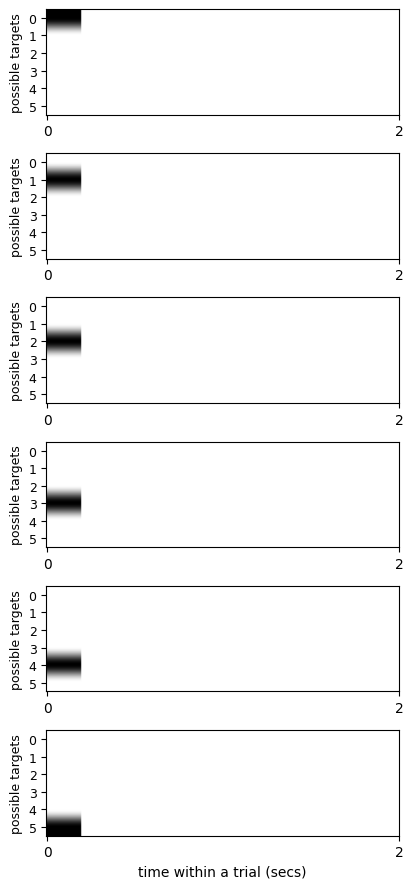

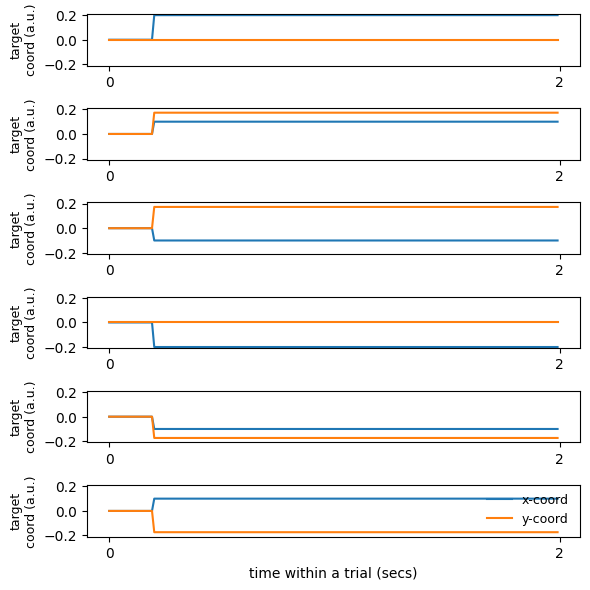

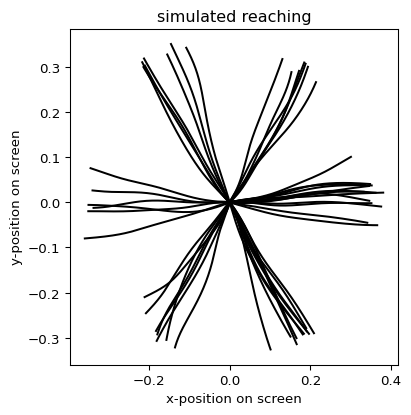

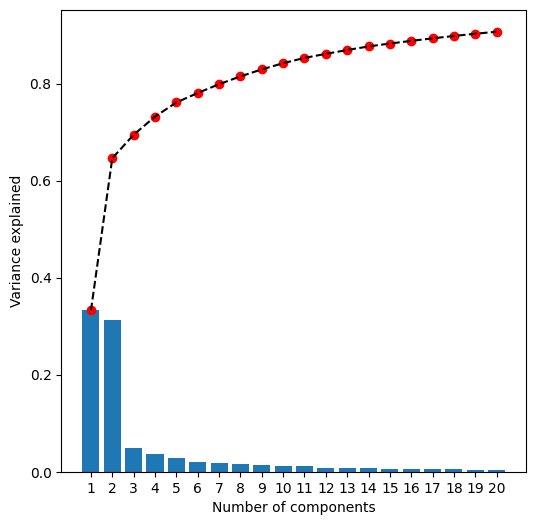

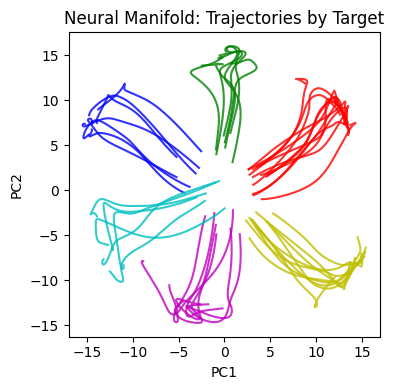

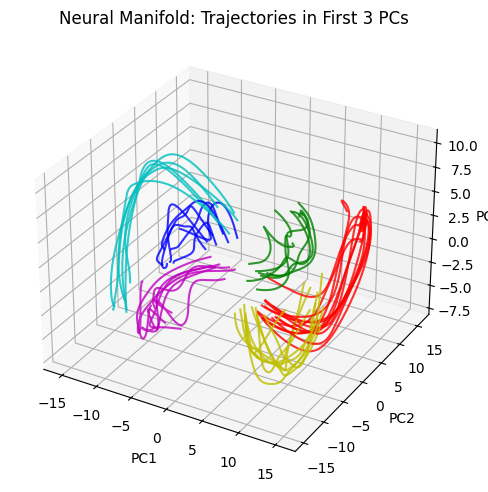

Loss in Trial 1 is 0.96742
Loss in Trial 2 is 3.57101
Loss in Trial 3 is 0.43799
Loss in Trial 4 is 1.46060
Loss in Trial 5 is 0.65522
Loss in Trial 6 is 2.48798
Loss in Trial 7 is 1.35856
Loss in Trial 8 is 0.32356
Loss in Trial 9 is 0.27887
Loss in Trial 10 is 1.36381
Loss in Trial 11 is 0.40816
Loss in Trial 12 is 0.96078
Loss in Trial 13 is 0.24809
Loss in Trial 14 is 0.20717
Loss in Trial 15 is 0.72901
Loss in Trial 16 is 0.68234
Loss in Trial 17 is 0.43769
Loss in Trial 18 is 0.23197
Loss in Trial 19 is 0.16271
Loss in Trial 20 is 0.24340
Loss in Trial 21 is 0.11338
Loss in Trial 22 is 0.48877
Loss in Trial 23 is 0.18648
Loss in Trial 24 is 0.54992
Loss in Trial 25 is 0.37912
Loss in Trial 26 is 0.87154
Loss in Trial 27 is 0.17511
Loss in Trial 28 is 0.68869
Loss in Trial 29 is 0.67158
Loss in Trial 30 is 0.56025
Loss in Trial 31 is 0.81341
Loss in Trial 32 is 0.43043
Loss in Trial 33 is 0.27433
Loss in Trial 34 is 0.60999
Loss in Trial 35 is 0.09265
Loss in Trial 36 is 0.13449
L

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed: 34.2min remaining: 17.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 50.9min finished


'\n"""## Create task 2: "force"\n\nDon\'t hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.\n\nCan you think of other tasks to test?\n"""\n\ntsteps = 200\npulse_length = 20\nT = 2\ntargets_list = [1, -1]\nn_targets = len(targets_list)\n\nstimulus = create_force_task_stimuli(tsteps, pulse_length, n_targets=n_targets)\nplot_force_stimuli(stimulus, n_targets, tsteps, T)\n\ntarget = create_force_task_targets(tsteps, pulse_length, targets=targets_list, target_max=0.2)\nplot_force_task_targets(target, tsteps, T)\n\nN_OUTPUT_UNITS_FORCE = 1\n\nforce_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=n_targets)\nsave_RNN(force_network, savedir)\n\nforce_decoder = create_reaching_task_decoder(force_network, N_OUTPUT_UNITS_FORCE)\n\nforce_feedback = get_feedback_weights(force_decoder)\n\nforce_loss = force_network.relearn(\n    n_learning1_trials, stimulus, pulse_length,\n    force_decoder, force_feedback, target, delta=delta\n)\

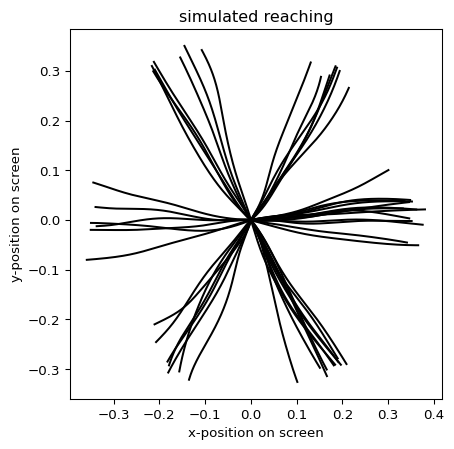

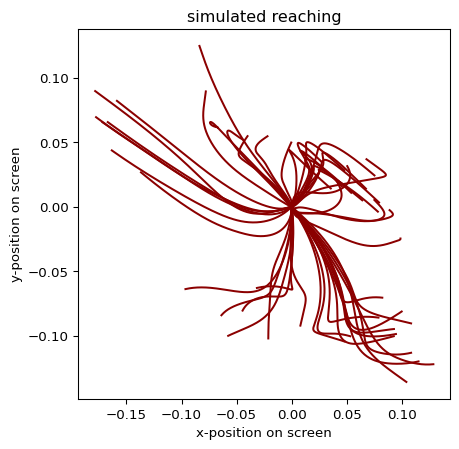

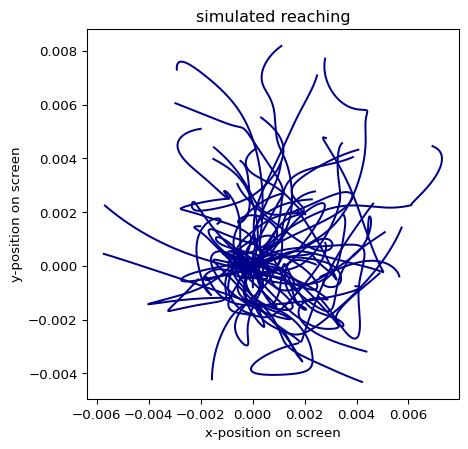

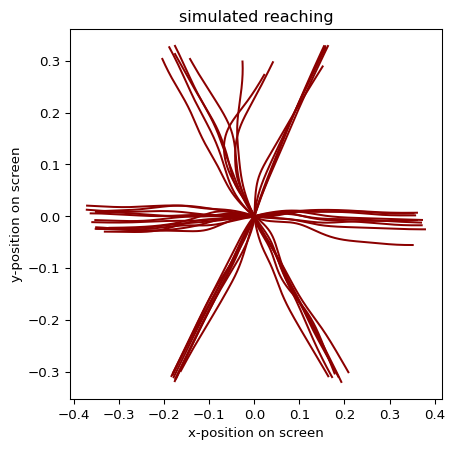

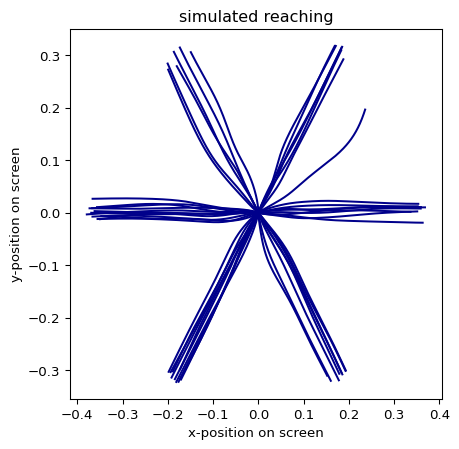

In [ ]:
# -*- coding: utf-8 -*-
"""motor_RNNs

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1psQV5sK5Ox0GU5uAzLaZ4urxTAFMs0BP

# Motor RNNs

contact: steeve.laquitaine@epfl.ch

Heavily inspired from [Feulner & Clopath, 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008621)

## Setup
"""

# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display

# @title Set the project path
proj_path = "C:/Users/arrac/Desktop/MotorRNN/proj_rnn/"
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/fig2/')
if not os.path.exists(savedir):
  os.makedirs(savedir)

"""## Utils

### Network
"""

# @title RNN encoder
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):

            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update
                        # plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm

            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

def save_RNN(network, savedir:str):
  """write RNN object and weights in savedir
  """
  network.save(savedir+'network')
  np.save(savedir+'W_initial', network.W)

def save_RNN_sinewave(network, savedir:str):
  """write RNN sinewave object and weights in savedir
  """
  network.save(savedir + 'network_sinewave')
  np.save(savedir + 'W_initial_sinewave', network.W)

# @title BCI decoders
def train_reaching_decoder(inputP, target, order, n_output_units:int=2):
    """train the decoder to perform the six-cue
    motor reaching task
    """
    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output_units))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X,Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

def create_reaching_task_decoder(reaching_network, n_output_units:int=2):
  """create feedforward decoder from RNN to (x,y) output units
  for learning (random weights)"""

  # set parameters
  SCALE = 0.04
  DENOM = 0.2

  # create random weights
  reaching_decoder = np.random.randn(n_output_units, reaching_network.N)
  initial_decoder_fac = SCALE * (target_max / DENOM)

  # normalize decoder matrix
  reaching_decoder *= (initial_decoder_fac / np.linalg.norm(reaching_decoder))
  return reaching_decoder

def train_force_exertion_decoder(inputP, target, order, n_output:int=1):
    """train the decoder to perform the force exertion
    motor task. The network must apply force at
    oscillating amplitude (following a sinewave function
    of time)
    """

    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X, Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

# @title Feedback weights
def get_feedback_weights(decoder):
  """calculate feedback weights from (x,y) output units back to RNN
  as the matrix inverse of the feedforward decoder weights from the RNN to
  the output units"""
  return np.linalg.pinv(decoder)

# @title Loss function
def get_cost(result, target, order):
  cost = 0
  for j in range(result.shape[0]):
    error = result[j, :, :] - target[order[j], :, :]
    cost += np.mean(error**2)
  return cost

# @title Get the manifold
def get_manifold(network):

  # calculate the manifold
  activity, cov, ev, evec, pr, xi, order = network.calculate_manifold(trials=manifold_trials, ext=stimulus, ntstart=pulse_length)

  # reshape the activity
  activity_reshaped = activity.reshape(manifold_trials, -1, network.N)
  xi2 = xi.reshape(manifold_trials, -1, network.N)
  return {"xi2":xi2, "order":order, "xi":xi, "cov":cov, "ev":ev, "evec":evec, "pr":pr,"activity":activity, "activity_reshaped":activity_reshaped}

def save_reaching_manifold(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results', dic)

def transform_reaching(reaching_network, manifold_out, W_bci4, n_output_units:int=2):

  P = manifold_out["evec"].real.T
  D = np.zeros((2, reaching_network.N))
  D[:,:reduced_dim] = W_bci4
  transformed = D @ P
  # result = manifold_out["activity_reshaped"] @ transformed.T
  # cost = get_cost(result, target[:,pulse_length:,:], manifold_out["order"])
  return transformed

# @title simulation
def simulate_reaching(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(activity.shape[1]):
      pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

def plot_variance_explained(evals, num_pc=10):
    var_explained = (evals) / np.sum(evals)
    csum_var_explained = np.cumsum(evals) / np.sum(evals)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.bar(np.arange(1, len(var_explained[:20]) + 1), var_explained[:20])
    ax.scatter(np.arange(1, len(csum_var_explained[:20]) + 1), csum_var_explained[:20], c='r')
    ax.plot(np.arange(1, len(csum_var_explained[:20]) + 1), csum_var_explained[:20],
             '--k')
    ax.set_xticks(np.arange(1, 21))
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Variance explained')
    # plt.grid('on')
    plt.show()
    return fig
"""### Task"""

# @title "reaching" task
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float):
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the computer screen (coordinate: (0,0))
    """
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):

        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])

        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def plot_reaching_task_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets,1)

  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))

  for target in stimulus_set:
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)

  axes[-1].set_xlabel("time within a trial (secs)")

  fig.tight_layout()

  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def plot_reaching_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6))
  for target_i in tuple(range(n_targets)):
    axes[target_i].plot(target[target_i,:,:])

    # legend
    axes[target_i].set_xticks([0, tsteps])
    axes[target_i].set_xticklabels([0, T])
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9)
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01])

  axes[-1].set_xlabel("time within a trial (secs)")
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False)
  fig.tight_layout()

# @title "force" task
def create_force_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=1, amplitude:float=1., twod:bool=False):
    """create a stimulus set

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float)
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimuli
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    for j in range(n_targets):
        stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def plot_force_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets, 1)
  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))
  for target in stimulus_set:

    # plot
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)
  axes[-1].set_xlabel("time within a trial (secs)")
  fig.tight_layout()
  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def create_force_task_targets(tsteps, pulse_steps, targets:list=[1, 10], target_max:float=0.2):
  """exert force with an oscillatorily increasing and decreasing amplitude
  """
  n_targets = len(targets)
  rs = np.zeros(tsteps)
  traj = np.zeros((n_targets, tsteps, 1))
  rs[pulse_steps:] = np.ones(tsteps - pulse_steps) * target_max
  x_coord = np.linspace(-2*np.pi, 2*np.pi, tsteps, endpoint=False)
  freq = []
  for ix in range(n_targets):
    traj[ix,:,0] = rs * np.sin(targets[ix] * x_coord)
  return traj

def plot_force_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6));
  for target_i in tuple(range(n_targets)):

    # plot
    axes[target_i].plot(target[target_i,:,:]);

    # legend
    axes[target_i].set_xticks([0, tsteps]);
    axes[target_i].set_xticklabels([0, T]);
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9);
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01]);
  axes[-1].set_xlabel("time within a trial (secs)");
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False);
  fig.tight_layout();

def plot_curser_trajectories(activity, decoder, color='k', alpha=1):
    """plot cursor trajectories for all targets/trials."""
    o_original = activity @ decoder.T

    # reconstruct trajectories from velocities
    pos_original = np.zeros(o_original.shape)
    for j in range(manifold_out['activity2'].shape[1]):
        pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

    # plot trajectories
    fig, ax = plt.subplots(figsize=(5, 5), dpi=96)
    for j in range(activity.shape[0]):
        plt.plot(pos_original[j,:,0], pos_original[j,:,1], color=color, alpha=alpha);
    ax.set_title('simulated reaching');
    ax.set_xlabel('x-position on screen');
    ax.set_ylabel('y-position on screen');

    return fig

def normalize_decoder(pert_decoder, orig_decoder):
    norm_orig = np.linalg.norm(orig_decoder, axis=1, keepdims=True)  # shape [2, 1]
    norm_pert = np.linalg.norm(pert_decoder, axis=1, keepdims=True)  # shape [2, 1]
    # Avoid divide-by-zero
    norm_pert[norm_pert == 0] = 1e-8
    normalized = pert_decoder * (norm_orig / norm_pert)
    return normalized\

def add_noise_to_feedback(feedback, alpha):
    sigma_original = np.std(feedback)
    noise = np.random.randn(*feedback.shape) * (alpha * sigma_original)
    return feedback + noise
# =============================================================================
# %%
# =============================================================================
"""## Create task 1: "reaching"
"""

# @title set parameters
# TODO: create dictionary

seed_id = 2                 # random seed for this simulation
np.random.seed(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 2                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 800                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.1                   # unit time constant tau (secs)
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)

# task parameters
targets = 6                 # number of reaching targets
stimulus_type = 'constant'  # constant, linear, normal
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = 80       # initial network learning
delta = 20.
relearning_trials = 80      # relearning
deltarec = 20.

# analyses parameters
manifold_trials = 50        # manifold calculation
reduced_dim = 10
# =============================================================================
# %%
# =============================================================================
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, twod=False)
plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

# create target (targets x timesteps x 2D coordinates) and plot
target = create_reaching_task_targets(
    tsteps,
    pulse_length,
    n_targets=targets,
    stype=stimulus_type,
    target_max=target_max
    )
plot_reaching_task_targets(target, tsteps, T)
# =============================================================================
# %%
# =============================================================================
# @title build and train the network
# create and save RNN encoder
reaching_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder = create_reaching_task_decoder(reaching_network,
                                                n_output_units=N_OUTPUT_UNITS)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback = get_feedback_weights(reaching_decoder)

# train and save the RNN encoder weights (learn the task)
reaching_loss = reaching_network.relearn(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder,
                                         reaching_feedback, target, delta=delta)
np.save(f'{savedir}W_stabilized_reaching', reaching_network.W)
w1_reaching = reaching_network.W.copy()

# get the RNN's manifold
manifold_out = get_manifold(reaching_network)

# train the decoder
W_bci4, l4 = train_reaching_decoder(manifold_out["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed = transform_reaching(reaching_network, manifold_out,
                                 W_bci4, n_output_units=N_OUTPUT_UNITS)
# =============================================================================
# %%
# =============================================================================
# @title Save run data
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results', run_data)

# save manifold data separately
save_reaching_manifold(run_data, transformed)
# =============================================================================
# %%
# =============================================================================
"""### simulate reaching"""

# simulate reaching
trajectories = simulate_reaching(savedir, dt)

run_data = np.load(f'{savedir}reaching_experiment_results.npy', allow_pickle=True).item()
manifold_out = run_data["manifold"]
fig = plot_variance_explained(manifold_out['ev'])


xi2 = manifold_out["xi2"]
pc1 = xi2[:, :, 0]
pc2 = xi2[:, :, 1]
n_trials = xi2.shape[0]

order = manifold_out["order"]
colors = ['r', 'g', 'b', 'c', 'm', 'y']
plt.figure(figsize=(4, 4))
for trial in range(n_trials):
    t_idx = order[trial] % len(colors)
    plt.plot(pc1[trial], pc2[trial], color=colors[t_idx], alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Neural Manifold: Trajectories by Target')
plt.tight_layout()
plt.show()

pc1 = xi2[:, :, 0]
pc2 = xi2[:, :, 1]
pc3 = xi2[:, :, 2]
from mpl_toolkits.mplot3d import Axes3D

order = manifold_out["order"]
colors = ['r', 'g', 'b', 'c', 'm', 'y']  # adjust for number of targets

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

for trial in range(xi2.shape[0]):
    t_idx = order[trial] % len(colors)
    ax.plot(pc1[trial], pc2[trial], pc3[trial], color=colors[t_idx], alpha=0.8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Neural Manifold: Trajectories in First 3 PCs')
plt.tight_layout()
plt.show()
# =============================================================================
# %%
# =============================================================================

run_data = np.load(f'{savedir}reaching_experiment_results.npy', allow_pickle=True).item()

manifold_out = run_data['manifold']
decoder_orig = run_data['decoding']['weights']
activity2 = manifold_out['activity2']  # [trials, tsteps, N]
xi2 = manifold_out['xi2']              # [trials, tsteps, n_components]
order = manifold_out['order']
target = run_data['target']
stimulus = run_data['stimulus']
pulse_length = run_data['params']['pulse_length']
N = run_data['params']['N']
reduced_dim = run_data['decoding']['reduced_dim']
T = run_data['params']['T']
dt = run_data['params']['dt']
n_learning_trials = run_data['stabilizing']['learning_trials']
delta = run_data['stabilizing']['delta']

fig = plot_curser_trajectories(manifold_out['activity2'], transformed)
from scipy.linalg import null_space

evec = manifold_out['evec']            # [N, N]
top_pc_basis = evec[:, :reduced_dim]   # [N, reduced_dim]

# 2. WITHIN-MANIFOLD: Random linear combination of top PCs
np.random.seed(42)
wmp_decoder = np.random.randn(2, reduced_dim) @ top_pc_basis.T
wmp_decoder = normalize_decoder(wmp_decoder, transformed)

fig = plot_curser_trajectories(manifold_out['activity2'], wmp_decoder, color='darkred')

# 3. OUTSIDE-MANIFOLD: Decoder in null space of manifold
null_basis = null_space(top_pc_basis.T)  # [N, N-reduced_dim]
# 2 random directions in null space
omp_decoder = np.random.randn(2, null_basis.shape[1]) @ null_basis.T
omp_decoder = normalize_decoder(omp_decoder, transformed)

fig = plot_curser_trajectories(manifold_out['activity2'], omp_decoder, color='darkblue')

wmp_feedback = get_feedback_weights(wmp_decoder)
omp_feedback = get_feedback_weights(omp_decoder)

reaching_network_wmp = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
reaching_network_wmp.W = np.load(f'{savedir}W_stabilized_reaching.npy')


# Within-manifold retraining
loss_wmp = reaching_network_wmp.relearn(
    n_learning_trials, stimulus, pulse_length,
    wmp_decoder, wmp_feedback, target, delta=delta
)

manifold_out_wmp = get_manifold(reaching_network_wmp)

fig = plot_curser_trajectories(manifold_out_wmp['activity_reshaped'], wmp_decoder, color='darkred')

reaching_network_omp = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
reaching_network_omp.W = np.load(f'{savedir}W_stabilized_reaching.npy')
# Outside-manifold retraining
loss_omp = reaching_network_omp.relearn(
    n_learning_trials, stimulus, pulse_length,
    omp_decoder, omp_feedback, target, delta=delta
)

manifold_out_omp = get_manifold(reaching_network_omp)

fig = plot_curser_trajectories(manifold_out_omp['activity_reshaped'], omp_decoder, color='darkblue')
# =============================================================================
# %%
# =============================================================================
alphas = np.linspace(0, 1, 5)

def retrain_with_noise(alpha, wmp_feedback, omp_feedback, wmp_decoder, omp_decoder,
                      n_learning_trials, stimulus, pulse_length, target, delta,
                      savedir, N, g, p, tau, dt, targets):
    # Add noise
    wmp_feedback_noisy = add_noise_to_feedback(wmp_feedback, alpha)
    omp_feedback_noisy = add_noise_to_feedback(omp_feedback, alpha)

    # Within-manifold retraining
    temp_network_wmp = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
    temp_network_wmp.W = np.load(f'{savedir}W_stabilized_reaching.npy')
    temp_loss_wmp = temp_network_wmp.relearn(
        n_learning_trials, stimulus, pulse_length,
        wmp_decoder, wmp_feedback_noisy, target, delta=delta
    )
    temp_manifold_wmp = get_manifold(temp_network_wmp)

    # Outside-manifold retraining
    temp_network_omp = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
    temp_network_omp.W = np.load(f'{savedir}W_stabilized_reaching.npy')
    temp_loss_omp = temp_network_omp.relearn(
        n_learning_trials, stimulus, pulse_length,
        omp_decoder, omp_feedback_noisy, target, delta=delta
    )
    temp_manifold_omp = get_manifold(temp_network_omp)

    return temp_loss_wmp, temp_manifold_wmp, temp_loss_omp, temp_manifold_omp


from joblib import Parallel, delayed

alphas = np.linspace(0, 1.0, 6)

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(retrain_with_noise)(
        alpha,
        wmp_feedback, omp_feedback,
        wmp_decoder, omp_decoder,
        n_learning_trials, stimulus, pulse_length, target, delta,
        savedir, N, g, p, tau, dt, targets
    ) for alpha in alphas
)

loss_wmp_noisy, manifold_out_wmp_noisy, loss_omp_noisy, manifold_out_omp_noisy = zip(*results)
# =============================================================================
# %%
# =============================================================================
'''
"""## Create task 2: "force"

Don't hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.

Can you think of other tasks to test?
"""

tsteps = 200
pulse_length = 20
T = 2
targets_list = [1, -1]
n_targets = len(targets_list)

stimulus = create_force_task_stimuli(tsteps, pulse_length, n_targets=n_targets)
plot_force_stimuli(stimulus, n_targets, tsteps, T)

target = create_force_task_targets(tsteps, pulse_length, targets=targets_list, target_max=0.2)
plot_force_task_targets(target, tsteps, T)

N_OUTPUT_UNITS_FORCE = 1

force_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=n_targets)
save_RNN(force_network, savedir)

force_decoder = create_reaching_task_decoder(force_network, N_OUTPUT_UNITS_FORCE)

force_feedback = get_feedback_weights(force_decoder)

force_loss = force_network.relearn(
    n_learning1_trials, stimulus, pulse_length,
    force_decoder, force_feedback, target, delta=delta
)
np.save(f'{savedir}W_stabilized_force', force_network.W)
w1_force = force_network.W.copy()

manifold_out_force = get_manifold(force_network)

W_bci4_force, l4_force = train_force_exertion_decoder(
    manifold_out_force["xi2"][:, :, :reduced_dim],
    target[:, pulse_length:, :],
    manifold_out_force["order"],
    n_output=N_OUTPUT_UNITS_FORCE
)

transformed_force = transform_reaching(
    force_network, manifold_out_force, W_bci4_force, n_output_units=N_OUTPUT_UNITS_FORCE
)

force_outputs = []
n_targets = stimulus.shape[0]
for trial in range(n_targets):
    stim = stimulus[trial]
    time, r, z = force_network.simulate(T, ext=stim)
    force_outputs.append(z)  # (tsteps, N)

decoded_force = []
for trial in range(len(force_outputs)):
    output = force_outputs[trial] @ force_decoder.T
    decoded_force.append(output)
# xi2 shape: (manifold_trials, tsteps, N)
decoded_force = manifold_out_force["xi2"] @ force_decoder.T  # (manifold_trials, tsteps, 1)
time_short = time[:decoded_force[0].shape[0]]

plt.figure(figsize=(12,6))
for trial in range(len(decoded_force)):
    plt.plot(time_short, decoded_force[trial].squeeze(), alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Decoded Force Output')
plt.title('Simulated Force Output Trajectories')
plt.show()
'''

In [ ]:
!git clone https://github.com/babaf/neural-manifold-and-plasticity.git

Cloning into 'neural-manifold-and-plasticity'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 31 (delta 12), reused 1 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 18.04 KiB | 636.00 KiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
%cd neural-manifold-and-plasticity


/content/neural-manifold-and-plasticity


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation script for Figure 2.
 -> perfect feedback signal
"""
# import packages
import numpy as np
import os
import sklearn.linear_model as lm

#######################
# SET DIRECTORY
#######################
# random seed for this simulation
seed_id = 2
# set directory where results should be saved
savdir = 'data/fig2/'
if not os.path.exists(savdir):
    os.mkdir(savdir)

#######################
# PARAMETERS
#######################
np.random.seed(seed_id)
dt = 0.01
T = 2
time = np.arange(0,T,dt)
tsteps = len(time)
pulse_length = int(0.2/dt)
targets = 6
stimulus_type = 'constant' # constant, linear, normal
target_max = 0.2 # 0.2 or 0.01
# initial network learning
learning1_trials = 80
delta = 20.
# manifold calculation
manifold_trials = 50
reduced_dim = 10
# relearning
relearning_trials = 80
deltarec = 20.

# network parameters
N = 800
g = 1.5
p = 0.1
tau = 0.1

##################
# TOOLBOX
#################
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r

        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        tsteps = ext.shape[1]
        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        record_loss = np.zeros(trials)
        # start learning
        for t in range(trials):
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()
            # loop over time
            for i in range(1,tsteps):
                self.update_neurons(ext=ext[order[t],i])
                # learning part
                if i > ntstart and i%2==0:
                    c = decoder @ self.z
                    errc = c-target[order[t],i]
                    err1 = feedback @ errc
                    loss += np.mean(err1**2)
                    # ONLY RECURRENT WEIGHT UPDATE
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

####################
# HELPER FUNCTIONS #
####################
def create_stimulus(tsteps,pulse_steps,n_targets=6,amplitude=1.,twod=False):
    # create stimulus
    stimulus = np.zeros((n_targets,tsteps,n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_target(tsteps,pulse_steps,n_targets=6,stype='constant',target_max=0.2):
    # create target trajectories
    phis = np.linspace(0,2*np.pi,n_targets,endpoint=False)
    rs = np.zeros(tsteps)
    # TARGET DEFINITION
    if stype=='linear':
        # OPTION 1) linear for position
        rs[pulse_steps:] = np.linspace(0,target_max,tsteps-pulse_steps)
    elif stype=='normal':
        # OPTION 2) Gaussian speed profile
        xx = np.linspace(0,target_max,tsteps-pulse_steps)
        mu = target_max/2.
        sigma = target_max/8.
        rs[pulse_steps:] = target_max*np.exp(-(xx-mu)**2/(2*sigma**2))
    elif stype=='constant':
        # OPTION 3) constant speed
        rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):
        traj[j,:,0] = rs*np.cos(phis[j])
        traj[j,:,1] = rs*np.sin(phis[j])

    return traj

def decoder_training(inputP,target,order):
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], 2))
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
#    print('MSE = %.4f'%mse)
    return reg.coef_,mse

def feedback_model_training(X,Y):
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    return reg.coef_

def get_cost(result,target,order):
    cost = 0
    for j in range(result.shape[0]):
        error = result[j,:,:]-target[order[j],:,:]
        cost += np.mean(error**2)
    return cost

def select_random_perturbations(activity2,D,P):
    runs = 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

#%% INITIAL TRAINING

# create stimulus
stimulus = create_stimulus(tsteps, pulse_length, n_targets=targets, twod=False)

# create target
target = create_target(tsteps, pulse_length, n_targets=targets,
                                  stype=stimulus_type, target_max=target_max)

# create network
network = RNN(N=N,g=g,p=p,tau=tau,dt=dt,N_in=targets)
network.save(savdir+'network')
np.save(savdir+'W_initial',network.W)
w0 = network.W.copy()

#######################
# LEARNING 1
#######################
# create random decoder for initial learning
decoder = np.random.randn(2,network.N)
initial_decoder_fac = 0.04 * (target_max/0.2)
decoder *= (initial_decoder_fac / np.linalg.norm(decoder))
feedback = np.linalg.pinv(decoder)
stabilize_loss = network.relearn(learning1_trials, stimulus, pulse_length,
                      decoder, feedback, target, delta=delta)
np.save(savdir+'W_stabilized',network.W)
w1 = network.W.copy()

#######################
# MANIFOLD
#######################
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
# rearrange the activity a bit
activity2 = activity.reshape(manifold_trials,-1,network.N)
xi2 = xi.reshape(manifold_trials,-1,network.N)

#######################
# LEARNING 2
#######################
W_bci4,l4 = decoder_training(xi2[:,:,:reduced_dim],target[:,pulse_length:,:],order)

#######################
# SAVING
#######################
data = {'params':{'dt':dt,
                 'T':T,
                 'time':time,
                 'tsteps':tsteps,
                 'pulse_length':pulse_length,
                 'manifold_trials':manifold_trials,
                 'target_max':target_max,
                 'stimulus_type':stimulus_type,
                 'N':N,'tau':tau,'g':g,'p':p},
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{'learning_trials':learning1_trials,
                   'delta':delta,
                 'decoder':decoder,
                 'feedback':feedback,
                 'stabilize_loss':stabilize_loss},
    'manifold':{'activity':activity,
                'activity2':activity2,
                'xi':xi,
                'xi2':xi2,
                'cov':cov,'ev':ev,'evec':evec,'pr':pr,'order':order},
    'decoding':{ 'reduced_dim':reduced_dim,
                 'weights':W_bci4,'loss':l4}}
np.save(savdir+'experiment_results',data)

#%% PERTURBATION

# original transformation
P = evec.real.T
D = np.zeros((2,network.N))
D[:,:reduced_dim] = W_bci4
T = D @ P
result_original = activity2 @ T.T
cost_original = get_cost(result_original,target[:,pulse_length:,:],order)

# select equal perturbation result shuffling seeds
idx_shuffling_seeds = select_random_perturbations(activity2,D,P) # within, outside
within_seed = idx_shuffling_seeds[0,0] # 79
outside_seed = idx_shuffling_seeds[0,1] # 189

#######################
# PERTURBATION
#######################
# within-manifold perturbation
np.random.seed(within_seed)
perm_matrix_within = np.eye(reduced_dim)
np.random.shuffle(perm_matrix_within)
D_permute = D.copy()
D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
T_within = D_permute @ P
result_within = activity2 @ T_within.T
cost_within = get_cost(result_within,target[:,pulse_length:,:],order)

# outside-manifold perturbation
np.random.seed(outside_seed)
perm_matrix_outside = np.eye(network.N)
np.random.shuffle(perm_matrix_outside)
P_permute = P @ perm_matrix_outside
T_outside = D @ P_permute
result_outside = activity2 @ T_outside.T
cost_outside = get_cost(result_outside,target[:,pulse_length:,:],order)

#%% RELEARNING

# set up readout and feedback
decoder_outside = T_outside
decoder_within = T_within
# FEEBACK OPTION 1: perfect teacher
feedback_within = np.linalg.pinv(decoder_within)
feedback_outside = np.linalg.pinv(decoder_outside)

# RETRAIN
network.W = np.copy(w1)
loss_within = network.relearn(relearning_trials, stimulus, pulse_length,
                      decoder_within, feedback_within, target, delta=deltarec)
w_within = np.copy(network.W)

network.W = np.copy(w1)
loss_outside = network.relearn(relearning_trials, stimulus, pulse_length,
                      decoder_outside, feedback_outside, target, delta=deltarec)
w_outside = np.copy(network.W)


#######################
# TESTING
#######################
# set weights
network.W = w_within
# simulate new activiy data
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
manifold = {'within':{'activity':activity,'xi':xi,'order':order,
                       'cov':cov,'ev':ev,'evec':evec,'pr':pr}}
# reshape
activity2 = activity.reshape(manifold_trials,-1,network.N)
# calculate output
result_within = activity2 @ T_within.T
cost_within_retrained = get_cost(result_within,target[:,pulse_length:,:],order)

# set weights
network.W = w_outside
# simulate new activiy data
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
manifold.update({'outside':{'activity':activity,'xi':xi,'order':order,
                       'cov':cov,'ev':ev,'evec':evec,'pr':pr}})
# reshape
activity2 = activity.reshape(manifold_trials,-1,network.N)
# calculate output
result_outside = activity2 @ T_outside.T
cost_outside_retrained = get_cost(result_outside,target[:,pulse_length:,:],order)

#####################
# SAVE
#####################
manifold.update({'original':data['manifold']})
dic = {'relearning':{
           'loss_outside':loss_outside,'loss_within':loss_within,
           'feedback_within':feedback_within,'feedback_outside':feedback_outside,
           'relearning_trials':relearning_trials,'delta':delta,
           'cost_within_retrained':cost_within_retrained,
           'cost_outside_retrained':cost_outside_retrained,
           'cost_within':cost_within,'cost_outside':cost_outside,
           'cost_original':cost_original},
       'manifold':manifold,
       'perturbations':
           {'within_seed':within_seed,'outside_seed':outside_seed,
            'P':P,'D':D,'T':T,'perm_matrix_outside':perm_matrix_outside,
            'perm_matrix_within':perm_matrix_within,'P_permute':P_permute,
            'D_permute':D_permute,'T_outside':T_outside,'T_within':T_within}}

np.save(savdir+'relearning_results',dic)
np.save(savdir+'W_within',w_within)
np.save(savdir+'W_outside',w_outside)



Loss in Trial 1 is 0.36486
Loss in Trial 2 is 0.53443
Loss in Trial 3 is 0.07616
Loss in Trial 4 is 0.32136
Loss in Trial 5 is 0.40796
Loss in Trial 6 is 0.52334
Loss in Trial 7 is 0.12490
Loss in Trial 8 is 0.16206
Loss in Trial 9 is 0.05343
Loss in Trial 10 is 0.30051
Loss in Trial 11 is 0.64470
Loss in Trial 12 is 0.10505
Loss in Trial 13 is 0.42285
Loss in Trial 14 is 0.18380
Loss in Trial 15 is 0.14192
Loss in Trial 16 is 0.12791
Loss in Trial 17 is 0.47923
Loss in Trial 18 is 0.11559
Loss in Trial 19 is 0.35033
Loss in Trial 20 is 0.08278
Loss in Trial 21 is 0.06807
Loss in Trial 22 is 0.06301
Loss in Trial 23 is 0.09566
Loss in Trial 24 is 0.12736
Loss in Trial 25 is 0.23735
Loss in Trial 26 is 0.23559
Loss in Trial 27 is 0.17402
Loss in Trial 28 is 0.08763
Loss in Trial 29 is 0.17927
Loss in Trial 30 is 0.14406
Loss in Trial 31 is 0.08725
Loss in Trial 32 is 0.06780
Loss in Trial 33 is 0.12969
Loss in Trial 34 is 0.29347
Loss in Trial 35 is 0.06320
Loss in Trial 36 is 0.04275
L

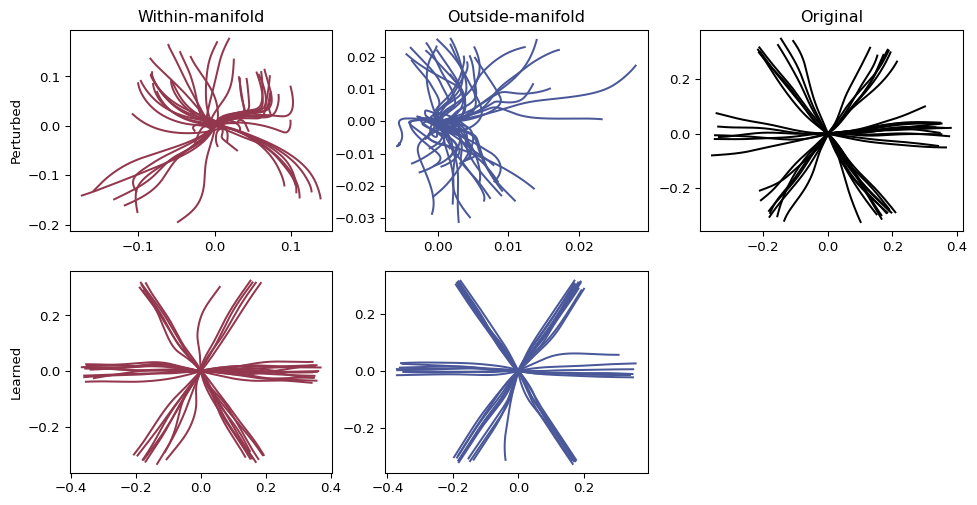

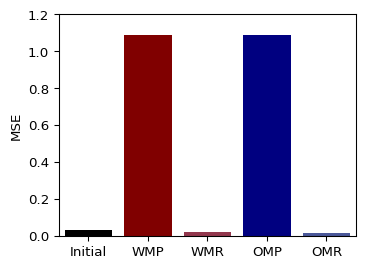

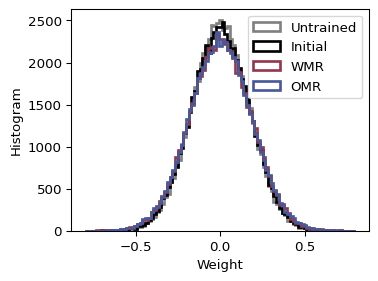

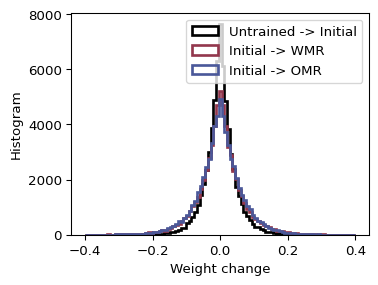

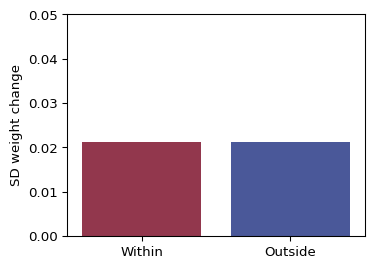

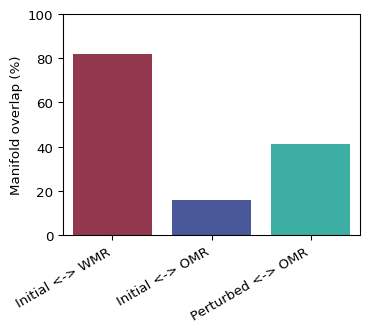

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Create plots for Figure 2.
"""

# import packages
import numpy as np
import matplotlib.pyplot as plt
import os

#######################
# SET DIRECTORY
#######################
loaddir = 'data/fig2/'
savdir = 'figures/fig2/'
if not os.path.exists(savdir):
    os.mkdir(savdir)

#######################
# LOAD SIMULATION DATA
#######################
# load main data dictionaries
data = np.load(loaddir+'relearning_results.npy',allow_pickle=True).item()
data0 = np.load(loaddir+'experiment_results.npy',allow_pickle=True).item()
# load parameters
dt = data0['params']['dt']
T = data0['params']['T']
time = data0['params']['time']
tsteps = data0['params']['tsteps']
pulse_length = data0['params']['pulse_length']
manifold_trials = data0['params']['manifold_trials']
stimulus = data0['stimulus']
target = data0['target']
reduced_dim = data0['decoding']['reduced_dim']
# load weights
w00 = np.load(loaddir+'W_initial.npy')
w0 = np.load(loaddir+'W_stabilized.npy')
w1w = np.load(loaddir+'W_within.npy')
w1o = np.load(loaddir+'W_outside.npy')
non0idx = np.where(w0!=0)
# load output
activity2 = data['manifold']['original']['activity2']
order_ori = data['manifold']['original']['order']
order_w = data['manifold']['within']['order']
order_o = data['manifold']['outside']['order']
o_original = activity2 @ data['perturbations']['T'].T
o_within_wrong = activity2 @ data['perturbations']['T_within'].T
o_outside_wrong = activity2 @ data['perturbations']['T_outside'].T
a_outside = data['manifold']['outside']['activity'].reshape((activity2.shape[0],
                activity2.shape[1],-1))
o_outside = a_outside[:,:,:data['perturbations']['T_outside'].shape[-1]] @ \
                data['perturbations']['T_outside'].T
a_within = data['manifold']['within']['activity'].reshape((activity2.shape[0],
                activity2.shape[1],-1))
o_within = a_within[:,:,:data['perturbations']['T_within'].shape[-1]] @ \
                data['perturbations']['T_within'].T

#######################
# ANALYSIS
#######################

# performance
performance = np.zeros(5)
performance[0] = data['relearning']['cost_original']
performance[1] = data['relearning']['cost_within']
performance[2] = data['relearning']['cost_within_retrained']
performance[3] = data['relearning']['cost_outside']
performance[4] = data['relearning']['cost_outside_retrained']

# weight change standard deviation
weights = np.zeros(2)
weights[0] = np.std(w1w-w0)
weights[1] = np.std(w1o-w0)

# explained variance (same measurement as in Golub et al. 2018 supplement)
explained_variance = np.zeros(3)
proj_original = data['manifold']['original']['evec'].T @  \
        data['manifold']['original']['cov'] @ data['manifold']['original']['evec']
proj_within = data['manifold']['original']['evec'].T @ \
        data['manifold']['within']['cov'] @ data['manifold']['original']['evec']
proj_outside = data['manifold']['original']['evec'].T @ \
        data['manifold']['outside']['cov'] @ data['manifold']['original']['evec']
proj_outside2 = data['perturbations']['P_permute'] @ \
                 data['manifold']['outside']['cov']  @ \
                data['perturbations']['P_permute'].T
overlap_original = np.trace(proj_original[:reduced_dim])/np.trace(data['manifold']['original']['cov'])
overlap_within = np.trace(proj_within[:reduced_dim])/np.trace(data['manifold']['within']['cov'])
overlap_outside = np.trace(proj_outside[:reduced_dim])/np.trace(data['manifold']['outside']['cov'])
overlap_outside2 = np.trace(proj_outside2[:reduced_dim])/np.trace(data['manifold']['outside']['cov'])
normExplainedVar_within = overlap_within/overlap_original
normExplainedVar_outside = overlap_outside/overlap_original
normExplainedVar_outside2 = overlap_outside2/overlap_original
explained_variance[0] = normExplainedVar_within
explained_variance[1] = normExplainedVar_outside
explained_variance[2] = normExplainedVar_outside2

#######################
# PLOTS
#######################
# set colors
col_oo = '#3CAEA3'
col_o = '#4a5899'
col_w = '#92374d'
col_ori = 'k'
col_pw = '#800000'
col_po = '#000080'

# FIGURE 1: trajectories
if data0['params']['stimulus_type']=='constant':
    # reconstruct trajectories from velocities
    pos_original = np.zeros(o_original.shape)
    pos_outside = np.zeros(o_outside.shape)
    pos_within = np.zeros(o_within.shape)
    pos_outside_wrong = np.zeros(o_outside.shape)
    pos_within_wrong = np.zeros(o_within.shape)
    for j in range(activity2.shape[1]):
        pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt
        pos_outside[:,j,:] = pos_outside[:,j-1,:] + o_outside[:,j,:]*dt
        pos_within[:,j,:] = pos_within[:,j-1,:] + o_within[:,j,:]*dt
        pos_outside_wrong[:,j,:] = pos_outside_wrong[:,j-1,:] + o_outside_wrong[:,j,:]*dt
        pos_within_wrong[:,j,:] = pos_within_wrong[:,j-1,:] + o_within_wrong[:,j,:]*dt
elif data0['params']['stimulus_type']=='linear':
    # reconstruct trajectories from velocities
    pos_original = o_original
    pos_outside = o_outside
    pos_within = o_within
    pos_outside_wrong = o_outside_wrong
    pos_within_wrong = o_within_wrong

plt.figure(figsize=(12,6),dpi=96)
alpha = 1
plt.subplot(2,3,1)
for j in range(manifold_trials):
    plt.plot(pos_within_wrong[j,:,0],pos_within_wrong[j,:,1],col_w,alpha=alpha)
plt.title('Within-manifold')
plt.ylabel('Perturbed')
plt.subplot(2,3,2)
for j in range(manifold_trials):
    plt.plot(pos_outside_wrong[j,:,0],pos_outside_wrong[j,:,1],col_o,alpha=alpha)
plt.title('Outside-manifold')
plt.subplot(2,3,4)
for j in range(manifold_trials):
    plt.plot(pos_within[j,:,0],pos_within[j,:,1],col_w,alpha=alpha)
plt.ylabel('Learned')
plt.subplot(2,3,5)
for j in range(manifold_trials):
    plt.plot(pos_outside[j,:,0],pos_outside[j,:,1],col_o,alpha=alpha)
plt.subplot(2,3,3)
for j in range(manifold_trials):
    plt.plot(pos_original[j,:,0],pos_original[j,:,1],col_ori,alpha=alpha)
plt.title('Original')
plt.savefig(savdir+'fig2A.svg',bbox_inches='tight')

# FIGURE 2: performance
cols = [col_ori,col_pw,col_w,col_po,col_o]
plt.figure(figsize=(4,3),dpi=96)
for j in range(performance.shape[-1]):
    plt.bar(j,np.mean(performance[j]),yerr=np.std(performance[j]),
            color=cols[j])
#    plt.violinplot(performance[:,j],[j],showmeans=True)
plt.xticks(range(performance.shape[-1]),['Initial','WMP',
           'WMR','OMP','OMR'])
plt.xlim(-0.5,4.5)
plt.ylim(0,1.2)
plt.ylabel('MSE')
plt.savefig(savdir+'fig2B.svg',bbox_inches='tight')


# FIGURE 3: weight change
bins = np.linspace(-0.8,0.8,100)
plt.figure(figsize=(4,3),dpi=96)
plt.hist(w00[non0idx],bins,histtype='step',linewidth=2,color='gray',
         label='Untrained')
plt.hist(w0[non0idx],bins,histtype='step',linewidth=2,color='k',
         label='Initial')
plt.hist(w1w[non0idx],bins,histtype='step',linewidth=2,color=col_w,
         label='WMR')
plt.hist(w1o[non0idx],bins,histtype='step',linewidth=2,color=col_o,
         label='OMR')
plt.legend(loc='upper right')
plt.xlabel('Weight')
plt.ylabel('Histogram')
plt.savefig(savdir+'fig2C_1.svg',bbox_inches='tight')

bins = np.linspace(-0.4,0.4,100)
plt.figure(figsize=(4,3),dpi=96)
plt.hist(w00[non0idx]-w0[non0idx],bins,histtype='step',linewidth=2,color='k',
         label='Untrained -> Initial')
plt.hist(w0[non0idx]-w1w[non0idx],bins,histtype='step',linewidth=2,color=col_w,
         label='Initial -> WMR')
plt.hist(w0[non0idx]-w1o[non0idx],bins,histtype='step',linewidth=2,color=col_o,
         label='Initial -> OMR')
plt.legend(loc='upper right')
plt.xlabel('Weight change')
plt.ylabel('Histogram')
plt.savefig(savdir+'fig2C_2.svg',bbox_inches='tight')

cols = [col_w,col_o]
plt.figure(figsize=(4,3),dpi=96)
for j in range(2):
    plt.bar(j,np.mean(weights[j]),yerr=np.std(weights[j]),
            color=cols[j])
plt.xticks(range(2),['Within','Outside'])
plt.xlim(-0.5,1.5)
plt.ylim(0,0.05)
plt.ylabel('SD weight change')
plt.savefig(savdir+'fig2C_3.svg',bbox_inches='tight')

# FIGURE 4: explained variance
cols = [col_w,col_o,col_oo]
plt.figure(figsize=(4,3),dpi=96)
for j in range(explained_variance.shape[-1]):
    plt.bar(j,explained_variance[j]*100,color=cols[j])
plt.xticks(range(explained_variance.shape[-1]),
           ['Initial <-> WMR','Initial <-> OMR','Perturbed <-> OMR'],
           rotation=30,ha='right')
plt.xlim(-0.5,2.5)
plt.ylim(0,100)
plt.ylabel('Manifold overlap (%)')
plt.savefig(savdir+'fig2D.svg',bbox_inches='tight')


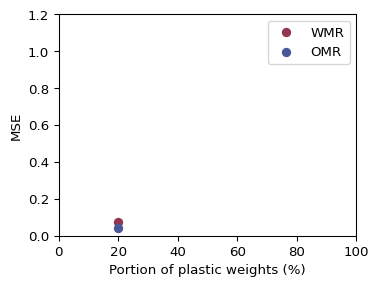

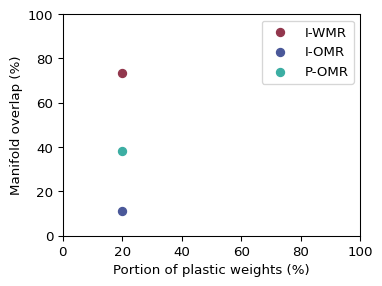

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Create plots for Figure 3.
"""

# import packages
import numpy as np
import matplotlib.pyplot as plt
import os

#######################
# SET DIRECTORY
#######################
loaddir = 'data/fig2/'
savdir = 'figures/fig2/'
if not os.path.exists(savdir):
    os.mkdir(savdir)

#######################
# LOAD SIMULATION DATA
#######################
# load main data dictionaries
data = np.load(loaddir+'relearning_results.npy',allow_pickle=True).item()
data0 = np.load(loaddir+'experiment_results.npy',allow_pickle=True).item()
# load parameters
dt = data0['params']['dt']
T = data0['params']['T']
time = data0['params']['time']
tsteps = data0['params']['tsteps']
pulse_length = data0['params']['pulse_length']
manifold_trials = data0['params']['manifold_trials']
stimulus = data0['stimulus']
target = data0['target']
reduced_dim = data0['decoding']['reduced_dim']
feedback_option = data['relearning']['feedback_option']
sd_fac = data['relearning']['sd_fac']
percent_silent = data['relearning']['percent_silent']
# load output
activity2 = data['manifold']['original']['activity2']
order_ori = data['manifold']['original']['order']
order_w = data['manifold']['within']['order']
order_o = data['manifold']['outside']['order']
o_original = activity2 @ data['perturbations']['T'].T
o_within_wrong = activity2 @ data['perturbations']['T_within'].T
o_outside_wrong = activity2 @ data['perturbations']['T_outside'].T
a_outside = data['manifold']['outside']['activity'].reshape((activity2.shape[0],
                activity2.shape[1],-1))
o_outside = a_outside[:,:,:data['perturbations']['T_outside'].shape[-1]] @ \
                data['perturbations']['T_outside'].T
a_within = data['manifold']['within']['activity'].reshape((activity2.shape[0],
                activity2.shape[1],-1))
o_within = a_within[:,:,:data['perturbations']['T_within'].shape[-1]] @ \
                data['perturbations']['T_within'].T

#######################
# ANALYSIS
#######################

# performance
performance = np.zeros(5)
performance[0] = data['relearning']['cost_original']
performance[1] = data['relearning']['cost_within']
performance[2] = data['relearning']['cost_within_retrained']
performance[3] = data['relearning']['cost_outside']
performance[4] = data['relearning']['cost_outside_retrained']

# explained variance (same measurement as in Golub et al. 2018 supplement)
explained_variance = np.zeros(3)
proj_original = data['manifold']['original']['evec'].T @  \
        data['manifold']['original']['cov'] @ data['manifold']['original']['evec']
proj_within = data['manifold']['original']['evec'].T @ \
        data['manifold']['within']['cov'] @ data['manifold']['original']['evec']
proj_outside = data['manifold']['original']['evec'].T @ \
        data['manifold']['outside']['cov'] @ data['manifold']['original']['evec']
proj_outside2 = data['perturbations']['P_permute'] @ \
                 data['manifold']['outside']['cov']  @ \
                data['perturbations']['P_permute'].T
overlap_original = np.trace(proj_original[:reduced_dim])/np.trace(data['manifold']['original']['cov'])
overlap_within = np.trace(proj_within[:reduced_dim])/np.trace(data['manifold']['within']['cov'])
overlap_outside = np.trace(proj_outside[:reduced_dim])/np.trace(data['manifold']['outside']['cov'])
overlap_outside2 = np.trace(proj_outside2[:reduced_dim])/np.trace(data['manifold']['outside']['cov'])
normExplainedVar_within = overlap_within/overlap_original
normExplainedVar_outside = overlap_outside/overlap_original
normExplainedVar_outside2 = overlap_outside2/overlap_original
explained_variance[0] = normExplainedVar_within
explained_variance[1] = normExplainedVar_outside
explained_variance[2] = normExplainedVar_outside2

#######################
# PLOTS
#######################
# set colors
col_oo = '#3CAEA3'
col_o = '#4a5899'
col_w = '#92374d'

if feedback_option=='B':
    # FIGURE 1: performance
    plt.figure(figsize=(4,3),dpi=96)
    plt.scatter(sd_fac,performance[2],c=col_w,label='WMR')
    plt.scatter(sd_fac,performance[4],c=col_o,label='OMR')
    plt.xlim(0,5)
    plt.ylim(0,1.2)
    plt.legend()
    plt.ylabel('MSE')
    plt.xlabel('Noise factor')
    plt.savefig(savdir+'performance.svg',bbox_inches='tight')

    # FIGURE 2: explained variance
    plt.figure(figsize=(4,3),dpi=96)
    plt.scatter(sd_fac,explained_variance[0]*100,c=col_w,label='I-WMR')
    plt.scatter(sd_fac,explained_variance[1]*100,c=col_o,label='I-OMR')
    plt.scatter(sd_fac,explained_variance[2]*100,c=col_oo,label='P-OMR')
    plt.xlim(0,5)
    plt.ylim(0,100)
    plt.legend()
    plt.ylabel('Manifold overlap (%)')
    plt.xlabel('Noise factor')
    plt.savefig(savdir+'manifold_overlap.svg',bbox_inches='tight')
elif feedback_option=='C':
    x = (1-percent_silent)*100
    # FIGURE 1: performance
    plt.figure(figsize=(4,3),dpi=96)
    plt.scatter(x,performance[2],c=col_w,label='WMR')
    plt.scatter(x,performance[4],c=col_o,label='OMR')
    plt.xlim(0,100)
    plt.ylim(0,1.2)
    plt.ylabel('MSE')
    plt.legend()
    plt.xlabel('Portion of neurons\nreceiving an error signal (%)')
    plt.savefig(savdir+'performance.svg',bbox_inches='tight')

    # FIGURE 2: explained variance
    plt.figure(figsize=(4,3),dpi=96)
    plt.scatter(x,explained_variance[0]*100,c=col_w,label='I-WMR')
    plt.scatter(x,explained_variance[1]*100,c=col_o,label='I-OMR')
    plt.scatter(x,explained_variance[2]*100,c=col_oo,label='P-OMR')
    plt.xlim(0,100)
    plt.legend()
    plt.ylim(0,100)
    plt.ylabel('Manifold overlap (%)')
    plt.xlabel('Portion of neurons\nreceiving an error signal (%)')
    plt.savefig(savdir+'manifold_overlap.svg',bbox_inches='tight')
elif feedback_option=='D':
    x = (1-percent_silent)*100
    # FIGURE 1: performance
    plt.figure(figsize=(4,3),dpi=96)
    plt.scatter(x,performance[2],c=col_w,label='WMR')
    plt.scatter(x,performance[4],c=col_o,label='OMR')
    plt.legend()
    plt.xlim(0,100)
    plt.ylim(0,1.2)
    plt.ylabel('MSE')
    plt.xlabel('Portion of plastic weights (%)')
    plt.savefig(savdir+'performance.svg',bbox_inches='tight')

    # FIGURE 2: explained variance
    plt.figure(figsize=(4,3),dpi=96)
    plt.scatter(x,explained_variance[0]*100,c=col_w,label='I-WMR')
    plt.scatter(x,explained_variance[1]*100,c=col_o,label='I-OMR')
    plt.scatter(x,explained_variance[2]*100,c=col_oo,label='P-OMR')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()
    plt.ylabel('Manifold overlap (%)')
    plt.xlabel('Portion of plastic weights (%)')
    plt.savefig(savdir+'manifold_overlap.svg',bbox_inches='tight')


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation script for Figure 3.
 -> imperfect feedback signal
"""
# import packages
import numpy as np
import os
import sklearn.linear_model as lm

#######################
# SET DIRECTORY
#######################
# random seed for this simulation
seed_id = 0
# set directory where results should be saved
savdir = 'data/fig2/'
if not os.path.exists(savdir):
    os.mkdir(savdir)

# set imperfect feedback variables
feedback_option = 'D' # B:noisy , C:sparse , D:less plastic weights
sd_fac = 2
percent_silent = 0.8

#######################
# PARAMETERS
#######################
np.random.seed(seed_id)
dt = 0.01
T = 2
time = np.arange(0,T,dt)
tsteps = len(time)
pulse_length = int(0.2/dt)
targets = 6
stimulus_type = 'constant' # constant, linear, normal
target_max = 0.2 # 0.2 or 0.01
# initial network learning
learning1_trials = 80
delta = 20.
# manifold calculation
manifold_trials = 50
reduced_dim = 10
# relearning
relearning_trials = 80
deltarec = 20.

# network parameters
N = 800
g = 1.5
p = 0.1
tau = 0.1

##################
# TOOLBOX
#################
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r

        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        tsteps = ext.shape[1]
        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        record_loss = np.zeros(trials)
        # start learning
        for t in range(trials):
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()
            # loop over time
            for i in range(1,tsteps):
                self.update_neurons(ext=ext[order[t],i])
                # learning part
                if i > ntstart and i%2==0:
                    c = decoder @ self.z
                    errc = c-target[order[t],i]
                    err1 = feedback @ errc
                    loss += np.mean(err1**2)
                    # ONLY RECURRENT WEIGHT UPDATE
                    for j in range(len(self.W_plastic)):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

####################
# HELPER FUNCTIONS #
####################
def create_stimulus(tsteps,pulse_steps,n_targets=6,amplitude=1.,twod=False):
    # create stimulus
    stimulus = np.zeros((n_targets,tsteps,n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_target(tsteps,pulse_steps,n_targets=6,stype='constant',target_max=0.2):
    # create target trajectories
    phis = np.linspace(0,2*np.pi,n_targets,endpoint=False)
    rs = np.zeros(tsteps)
    # TARGET DEFINITION
    if stype=='linear':
        # OPTION 1) linear for position
        rs[pulse_steps:] = np.linspace(0,target_max,tsteps-pulse_steps)
    elif stype=='normal':
        # OPTION 2) Gaussian speed profile
        xx = np.linspace(0,target_max,tsteps-pulse_steps)
        mu = target_max/2.
        sigma = target_max/8.
        rs[pulse_steps:] = target_max*np.exp(-(xx-mu)**2/(2*sigma**2))
    elif stype=='constant':
        # OPTION 3) constant speed
        rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):
        traj[j,:,0] = rs*np.cos(phis[j])
        traj[j,:,1] = rs*np.sin(phis[j])

    return traj

def decoder_training(inputP,target,order):
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], 2))
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
#    print('MSE = %.4f'%mse)
    return reg.coef_,mse

def feedback_model_training(X,Y):
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    return reg.coef_

def get_cost(result,target,order):
    cost = 0
    for j in range(result.shape[0]):
        error = result[j,:,:]-target[order[j],:,:]
        cost += np.mean(error**2)
    return cost

def select_random_perturbations(activity2,D,P):
    runs = 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

#%% INITIAL TRAINING

# create stimulus
stimulus = create_stimulus(tsteps, pulse_length, n_targets=targets, twod=False)

# create target
target = create_target(tsteps, pulse_length, n_targets=targets,
                                  stype=stimulus_type, target_max=target_max)

# create network
network = RNN(N=N,g=g,p=p,tau=tau,dt=dt,N_in=targets)
network.save(savdir+'network')
np.save(savdir+'W_initial',network.W)
w0 = network.W.copy()

#######################
# LEARNING 1
#######################
# create random decoder for initial learning
decoder = np.random.randn(2,network.N)
initial_decoder_fac = 0.04 * (target_max/0.2)
decoder *= (initial_decoder_fac / np.linalg.norm(decoder))
feedback = np.linalg.pinv(decoder)
stabilize_loss = network.relearn(learning1_trials, stimulus, pulse_length,
                      decoder, feedback, target, delta=delta)
np.save(savdir+'W_stabilized',network.W)
w1 = network.W.copy()

#######################
# MANIFOLD
#######################
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
# rearrange the activity a bit
activity2 = activity.reshape(manifold_trials,-1,network.N)
xi2 = xi.reshape(manifold_trials,-1,network.N)

#######################
# LEARNING 2
#######################
W_bci4,l4 = decoder_training(xi2[:,:,:reduced_dim],target[:,pulse_length:,:],order)

#######################
# SAVING
#######################
data = {'params':{'dt':dt,
                 'T':T,
                 'time':time,
                 'tsteps':tsteps,
                 'pulse_length':pulse_length,
                 'manifold_trials':manifold_trials,
                 'target_max':target_max,
                 'stimulus_type':stimulus_type,
                 'N':N,'tau':tau,'g':g,'p':p},
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{'learning_trials':learning1_trials,
                   'delta':delta,
                 'decoder':decoder,
                 'feedback':feedback,
                 'stabilize_loss':stabilize_loss},
    'manifold':{'activity':activity,
                'activity2':activity2,
                'xi':xi,
                'xi2':xi2,
                'cov':cov,'ev':ev,'evec':evec,'pr':pr,'order':order},
    'decoding':{ 'reduced_dim':reduced_dim,
                 'weights':W_bci4,'loss':l4}}
np.save(savdir+'experiment_results',data)

#%% PERTURBATION

# original transformation
P = evec.real.T
D = np.zeros((2,network.N))
D[:,:reduced_dim] = W_bci4
T = D @ P
result_original = activity2 @ T.T
cost_original = get_cost(result_original,target[:,pulse_length:,:],order)

# select equal perturbation result shuffling seeds
idx_shuffling_seeds = select_random_perturbations(activity2,D,P) # within, outside
within_seed = idx_shuffling_seeds[0,0] # 79
outside_seed = idx_shuffling_seeds[0,1] # 189

#######################
# PERTURBATION
#######################
# within-manifold perturbation
np.random.seed(within_seed)
perm_matrix_within = np.eye(reduced_dim)
np.random.shuffle(perm_matrix_within)
D_permute = D.copy()
D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
T_within = D_permute @ P
result_within = activity2 @ T_within.T
cost_within = get_cost(result_within,target[:,pulse_length:,:],order)

# outside-manifold perturbation
np.random.seed(outside_seed)
perm_matrix_outside = np.eye(network.N)
np.random.shuffle(perm_matrix_outside)
P_permute = P @ perm_matrix_outside
T_outside = D @ P_permute
result_outside = activity2 @ T_outside.T
cost_outside = get_cost(result_outside,target[:,pulse_length:,:],order)

#%% RELEARNING

# set up readout and feedback
decoder_outside = T_outside
decoder_within = T_within
new_w_plastic = None

if feedback_option=='A':
    # FEEBACK OPTION A: perfect teacher
    feedback_within = np.linalg.pinv(decoder_within) # retraining1
    feedback_outside = np.linalg.pinv(decoder_outside) # retraining1
elif feedback_option=='B':
    # FEEBACK OPTION B: noise on top of correct feedback
    feedback_within = np.linalg.pinv(decoder_within)
    feedback_outside = np.linalg.pinv(decoder_outside)
    # noise with sd_fac x signal-to-noise ratio
    noise_within = sd_fac*np.std(feedback_within) * np.random.randn(feedback_within.shape[0],
                                                     feedback_within.shape[1])
    noise_outside = sd_fac*np.std(feedback_outside) * np.random.randn(feedback_outside.shape[0],
                                                     feedback_outside.shape[1])
    feedback_within += noise_within
    feedback_outside += noise_outside
elif feedback_option=='C':
    # FEEBACK OPTION C: some feedback weights are 0 -> reduce number of plastic neurons
    feedback_within = np.linalg.pinv(decoder_within)
    feedback_outside = np.linalg.pinv(decoder_outside)
    maskt = np.random.rand(feedback_within.shape[0])<percent_silent
    feedback_within[maskt,:] = 0 # retraining3
    feedback_outside[maskt,:] = 0 # retraining3
    # also change wplastic to speed up simulation
    new_w_plastic = [np.where(network.W[i,:]!=0)[0] for i in np.where(maskt==False)[0]]
elif feedback_option=='D':
    # FEEBACK OPTION D: proportion of incoming weights are set non-plastic
    feedback_within = np.linalg.pinv(decoder_within)
    feedback_outside = np.linalg.pinv(decoder_outside)
    new_w_plastic = []
    for i in range(network.N):
        allc = np.where(network.W[i,:]!=0)[0]
        smallc = np.random.choice(allc,int((1-percent_silent)*len(allc)),replace=False)
        new_w_plastic.append(smallc)

# RETRAIN
network.W = np.copy(w1)
loss_within = network.relearn(relearning_trials, stimulus, pulse_length,
                      decoder_within, feedback_within, target, delta=deltarec,
                      wplastic=new_w_plastic)
w_within = np.copy(network.W)

network.W = np.copy(w1)
loss_outside = network.relearn(relearning_trials, stimulus, pulse_length,
                      decoder_outside, feedback_outside, target, delta=deltarec,
                      wplastic=new_w_plastic)
w_outside = np.copy(network.W)


#######################
# TESTING
#######################
# set weights
network.W = w_within
# simulate new activiy data
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
manifold = {'within':{'activity':activity,'xi':xi,'order':order,
                       'cov':cov,'ev':ev,'evec':evec,'pr':pr}}
# reshape
activity2 = activity.reshape(manifold_trials,-1,network.N)
# calculate output
result_within = activity2 @ T_within.T
cost_within_retrained = get_cost(result_within,target[:,pulse_length:,:],order)

# set weights
network.W = w_outside
# simulate new activiy data
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
manifold.update({'outside':{'activity':activity,'xi':xi,'order':order,
                       'cov':cov,'ev':ev,'evec':evec,'pr':pr}})
# reshape
activity2 = activity.reshape(manifold_trials,-1,network.N)
# calculate output
result_outside = activity2 @ T_outside.T
cost_outside_retrained = get_cost(result_outside,target[:,pulse_length:,:],order)

#####################
# SAVE
#####################
manifold.update({'original':data['manifold']})
dic = {'relearning':{
           'loss_outside':loss_outside,'loss_within':loss_within,
           'feedback_within':feedback_within,'feedback_outside':feedback_outside,
           'relearning_trials':relearning_trials,'delta':delta,
           'cost_within_retrained':cost_within_retrained,
           'cost_outside_retrained':cost_outside_retrained,
           'cost_within':cost_within,'cost_outside':cost_outside,
           'cost_original':cost_original,'percent_silent':percent_silent,
           'feedback_option':feedback_option,'sd_fac':sd_fac},
       'manifold':manifold,
       'perturbations':
           {'within_seed':within_seed,'outside_seed':outside_seed,
            'P':P,'D':D,'T':T,'perm_matrix_outside':perm_matrix_outside,
            'perm_matrix_within':perm_matrix_within,'P_permute':P_permute,
            'D_permute':D_permute,'T_outside':T_outside,'T_within':T_within}}

np.save(savdir+'relearning_results',dic)
np.save(savdir+'W_within',w_within)
np.save(savdir+'W_outside',w_outside)



Loss in Trial 1 is 0.27946
Loss in Trial 2 is 0.41030
Loss in Trial 3 is 0.35385
Loss in Trial 4 is 0.49794
Loss in Trial 5 is 0.28733
Loss in Trial 6 is 0.17139
Loss in Trial 7 is 0.05654
Loss in Trial 8 is 0.17779
Loss in Trial 9 is 0.18429
Loss in Trial 10 is 0.18636
Loss in Trial 11 is 0.06259
Loss in Trial 12 is 0.03793
Loss in Trial 13 is 0.17822
Loss in Trial 14 is 0.15581
Loss in Trial 15 is 0.04635
Loss in Trial 16 is 0.08512
Loss in Trial 17 is 0.14569
Loss in Trial 18 is 0.66442
Loss in Trial 19 is 0.10020
Loss in Trial 20 is 0.36279
Loss in Trial 21 is 0.15580
Loss in Trial 22 is 0.08154
Loss in Trial 23 is 0.21556
Loss in Trial 24 is 0.20724
Loss in Trial 25 is 0.12186
Loss in Trial 26 is 0.07748
Loss in Trial 27 is 0.22244
Loss in Trial 28 is 0.07307
Loss in Trial 29 is 0.19566
Loss in Trial 30 is 0.05026
Loss in Trial 31 is 0.03981
Loss in Trial 32 is 0.10544
Loss in Trial 33 is 0.09847
Loss in Trial 34 is 0.24635
Loss in Trial 35 is 0.21646
Loss in Trial 36 is 0.10149
L

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation script for Figure 4.
 -> learned feedback signal
"""
# import packages
import numpy as np
import os
import sklearn.linear_model as lm

#######################
# SET DIRECTORY
#######################
# random seed for this simulation
seed_id = 0
# set directory where results should be saved
savdir = 'data/fig4/'
if not os.path.exists(savdir):
    os.mkdir(savdir)

#######################
# PARAMETERS
#######################
np.random.seed(seed_id)
dt = 0.01
T = 2
time = np.arange(0,T,dt)
tsteps = len(time)
pulse_length = int(0.2/dt)
targets = 6
stimulus_type = 'constant' # constant, linear, normal
target_max = 0.2 # 0.2 or 0.01
# initial network learning
learning1_trials = 80
delta = 20.
# manifold calculation
manifold_trials = 50
reduced_dim = 10
# relearning
relearning_trials = 80
deltarec = 20.

# network parameters
N = 800
g = 1.5
p = 0.1
tau = 0.1

##################
# TOOLBOX
#################
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r

        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        tsteps = ext.shape[1]
        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        record_loss = np.zeros(trials)
        # start learning
        for t in range(trials):
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()
            # loop over time
            for i in range(1,tsteps):
                self.update_neurons(ext=ext[order[t],i])
                # learning part
                if i > ntstart and i%2==0:
                    c = decoder @ self.z
                    errc = c-target[order[t],i]
                    err1 = feedback @ errc
                    loss += np.mean(err1**2)
                    # ONLY RECURRENT WEIGHT UPDATE
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

####################
# HELPER FUNCTIONS #
####################
def create_stimulus(tsteps,pulse_steps,n_targets=6,amplitude=1.,twod=False):
    # create stimulus
    stimulus = np.zeros((n_targets,tsteps,n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_target(tsteps,pulse_steps,n_targets=6,stype='constant',target_max=0.2):
    # create target trajectories
    phis = np.linspace(0,2*np.pi,n_targets,endpoint=False)
    rs = np.zeros(tsteps)
    # TARGET DEFINITION
    if stype=='linear':
        # OPTION 1) linear for position
        rs[pulse_steps:] = np.linspace(0,target_max,tsteps-pulse_steps)
    elif stype=='normal':
        # OPTION 2) Gaussian speed profile
        xx = np.linspace(0,target_max,tsteps-pulse_steps)
        mu = target_max/2.
        sigma = target_max/8.
        rs[pulse_steps:] = target_max*np.exp(-(xx-mu)**2/(2*sigma**2))
    elif stype=='constant':
        # OPTION 3) constant speed
        rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):
        traj[j,:,0] = rs*np.cos(phis[j])
        traj[j,:,1] = rs*np.sin(phis[j])

    return traj

def decoder_training(inputP,target,order):
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], 2))
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
#    print('MSE = %.4f'%mse)
    return reg.coef_,mse

def feedback_model_training(X,Y):
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    return reg.coef_

def get_cost(result,target,order):
    cost = 0
    for j in range(result.shape[0]):
        error = result[j,:,:]-target[order[j],:,:]
        cost += np.mean(error**2)
    return cost

def select_random_perturbations(activity2,D,P):
    runs = 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

#%% INITIAL TRAINING

# create stimulus
stimulus = create_stimulus(tsteps, pulse_length, n_targets=targets, twod=False)

# create target
target = create_target(tsteps, pulse_length, n_targets=targets,
                                  stype=stimulus_type, target_max=target_max)

# create network
network = RNN(N=N,g=g,p=p,tau=tau,dt=dt,N_in=targets)
network.save(savdir+'network')
np.save(savdir+'W_initial',network.W)
w0 = network.W.copy()

#######################
# LEARNING 1
#######################
# create random decoder for initial learning
decoder = np.random.randn(2,network.N)
initial_decoder_fac = 0.04 * (target_max/0.2)
decoder *= (initial_decoder_fac / np.linalg.norm(decoder))
feedback = np.linalg.pinv(decoder)
stabilize_loss = network.relearn(learning1_trials, stimulus, pulse_length,
                      decoder, feedback, target, delta=delta)
np.save(savdir+'W_stabilized',network.W)
w1 = network.W.copy()

#######################
# MANIFOLD
#######################
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
# rearrange the activity a bit
activity2 = activity.reshape(manifold_trials,-1,network.N)
xi2 = xi.reshape(manifold_trials,-1,network.N)

#######################
# LEARNING 2
#######################
W_bci4,l4 = decoder_training(xi2[:,:,:reduced_dim],target[:,pulse_length:,:],order)

#######################
# SAVING
#######################
data = {'params':{'dt':dt,
                 'T':T,
                 'time':time,
                 'tsteps':tsteps,
                 'pulse_length':pulse_length,
                 'manifold_trials':manifold_trials,
                 'target_max':target_max,
                 'stimulus_type':stimulus_type,
                 'N':N,'tau':tau,'g':g,'p':p},
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{'learning_trials':learning1_trials,
                   'delta':delta,
                 'decoder':decoder,
                 'feedback':feedback,
                 'stabilize_loss':stabilize_loss},
    'manifold':{'activity':activity,
                'activity2':activity2,
                'xi':xi,
                'xi2':xi2,
                'cov':cov,'ev':ev,'evec':evec,'pr':pr,'order':order},
    'decoding':{ 'reduced_dim':reduced_dim,
                 'weights':W_bci4,'loss':l4}}
np.save(savdir+'experiment_results',data)

#%% PERTURBATION

# original transformation
P = evec.real.T
D = np.zeros((2,network.N))
D[:,:reduced_dim] = W_bci4
T = D @ P
result_original = activity2 @ T.T
cost_original = get_cost(result_original,target[:,pulse_length:,:],order)

# select equal perturbation result shuffling seeds
idx_shuffling_seeds = select_random_perturbations(activity2,D,P) # within, outside
within_seed = idx_shuffling_seeds[0,0] # 79
outside_seed = idx_shuffling_seeds[0,1] # 189

#######################
# PERTURBATION
#######################
# within-manifold perturbation
np.random.seed(within_seed)
perm_matrix_within = np.eye(reduced_dim)
np.random.shuffle(perm_matrix_within)
D_permute = D.copy()
D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
T_within = D_permute @ P
result_within = activity2 @ T_within.T
cost_within = get_cost(result_within,target[:,pulse_length:,:],order)

# outside-manifold perturbation
np.random.seed(outside_seed)
perm_matrix_outside = np.eye(network.N)
np.random.shuffle(perm_matrix_outside)
P_permute = P @ perm_matrix_outside
T_outside = D @ P_permute
result_outside = activity2 @ T_outside.T
cost_outside = get_cost(result_outside,target[:,pulse_length:,:],order)

#%% RELEARNING

# set up readout and feedback
decoder_outside = T_outside
decoder_within = T_within
# FEEBACK OPTION 6: load 'learned' feedback
feedback_within = feedback_model_training(activity @ T_within.T,activity)
feedback_outside = feedback_model_training(activity @ T_outside.T ,activity)

# RETRAIN
network.W = np.copy(w1)
loss_within = network.relearn(relearning_trials, stimulus, pulse_length,
                      decoder_within, feedback_within, target, delta=deltarec)
w_within = np.copy(network.W)

network.W = np.copy(w1)
loss_outside = network.relearn(relearning_trials, stimulus, pulse_length,
                      decoder_outside, feedback_outside, target, delta=deltarec)
w_outside = np.copy(network.W)


#######################
# TESTING
#######################
# set weights
network.W = w_within
# simulate new activiy data
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
manifold = {'within':{'activity':activity,'xi':xi,'order':order,
                       'cov':cov,'ev':ev,'evec':evec,'pr':pr}}
# reshape
activity2 = activity.reshape(manifold_trials,-1,network.N)
# calculate output
result_within = activity2 @ T_within.T
cost_within_retrained = get_cost(result_within,target[:,pulse_length:,:],order)

# set weights
network.W = w_outside
# simulate new activiy data
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
manifold.update({'outside':{'activity':activity,'xi':xi,'order':order,
                       'cov':cov,'ev':ev,'evec':evec,'pr':pr}})
# reshape
activity2 = activity.reshape(manifold_trials,-1,network.N)
# calculate output
result_outside = activity2 @ T_outside.T
cost_outside_retrained = get_cost(result_outside,target[:,pulse_length:,:],order)

#####################
# SAVE
#####################
manifold.update({'original':data['manifold']})
dic = {'relearning':{
           'loss_outside':loss_outside,'loss_within':loss_within,
           'feedback_within':feedback_within,'feedback_outside':feedback_outside,
           'relearning_trials':relearning_trials,'delta':delta,
           'cost_within_retrained':cost_within_retrained,
           'cost_outside_retrained':cost_outside_retrained,
           'cost_within':cost_within,'cost_outside':cost_outside,
           'cost_original':cost_original},
       'manifold':manifold,
       'perturbations':
           {'within_seed':within_seed,'outside_seed':outside_seed,
            'P':P,'D':D,'T':T,'perm_matrix_outside':perm_matrix_outside,
            'perm_matrix_within':perm_matrix_within,'P_permute':P_permute,
            'D_permute':D_permute,'T_outside':T_outside,'T_within':T_within}}

np.save(savdir+'relearning_results',dic)
np.save(savdir+'W_within',w_within)
np.save(savdir+'W_outside',w_outside)



Loss in Trial 1 is 0.27946
Loss in Trial 2 is 0.41030
Loss in Trial 3 is 0.35385
Loss in Trial 4 is 0.49794
Loss in Trial 5 is 0.28733
Loss in Trial 6 is 0.17139
Loss in Trial 7 is 0.05654
Loss in Trial 8 is 0.17779
Loss in Trial 9 is 0.18429
Loss in Trial 10 is 0.18636
Loss in Trial 11 is 0.06259
Loss in Trial 12 is 0.03793
Loss in Trial 13 is 0.17822
Loss in Trial 14 is 0.15581
Loss in Trial 15 is 0.04635
Loss in Trial 16 is 0.08512
Loss in Trial 17 is 0.14569
Loss in Trial 18 is 0.66442
Loss in Trial 19 is 0.10020
Loss in Trial 20 is 0.36279
Loss in Trial 21 is 0.15580
Loss in Trial 22 is 0.08154
Loss in Trial 23 is 0.21556
Loss in Trial 24 is 0.20724
Loss in Trial 25 is 0.12186
Loss in Trial 26 is 0.07748
Loss in Trial 27 is 0.22244
Loss in Trial 28 is 0.07307
Loss in Trial 29 is 0.19566
Loss in Trial 30 is 0.05026
Loss in Trial 31 is 0.03981
Loss in Trial 32 is 0.10544
Loss in Trial 33 is 0.09847
Loss in Trial 34 is 0.24635
Loss in Trial 35 is 0.21646
Loss in Trial 36 is 0.10149
L

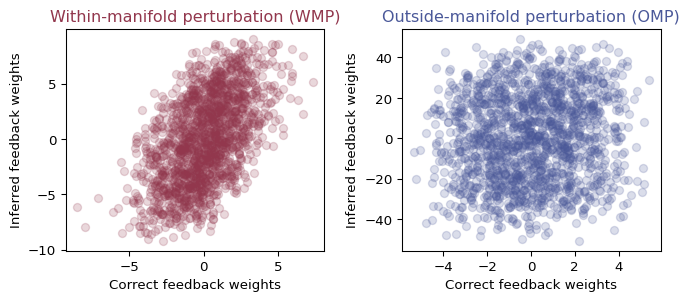

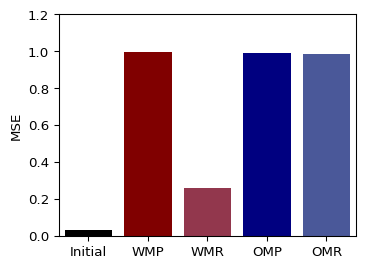

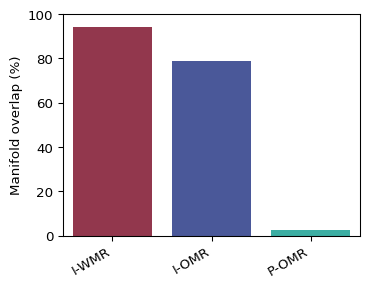

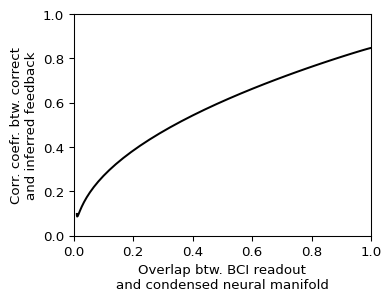

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Create plots for Figure 4.
"""

# import packages
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn.linear_model as lm

#######################
# SET DIRECTORY
#######################
loaddir = 'data/fig4/'
savdir = 'figures/fig4/'
if not os.path.exists(savdir):
    os.mkdir(savdir)

#######################
# LOAD SIMULATION DATA
#######################
# load main data dictionaries
data = np.load(loaddir+'relearning_results.npy',allow_pickle=True).item()
data0 = np.load(loaddir+'experiment_results.npy',allow_pickle=True).item()
# load parameters
manifold_trials = data0['params']['manifold_trials']
stimulus = data0['stimulus']
target = data0['target']
reduced_dim = data0['decoding']['reduced_dim']
T = data['perturbations']['T']
T_within = data['perturbations']['T_within']
T_outside = data['perturbations']['T_outside']
feedback_within = data['relearning']['feedback_within']
feedback_outside = data['relearning']['feedback_outside']
# load weights
w00 = np.load(loaddir+'W_initial.npy')
w0 = np.load(loaddir+'W_stabilized.npy')
w1w = np.load(loaddir+'W_within.npy')
w1o = np.load(loaddir+'W_outside.npy')
non0idx = np.where(w0!=0)
# load output
activity2 = data['manifold']['original']['activity2']
order_ori = data['manifold']['original']['order']
order_w = data['manifold']['within']['order']
order_o = data['manifold']['outside']['order']
o_original = activity2 @ data['perturbations']['T'].T
o_within_wrong = activity2 @ data['perturbations']['T_within'].T
o_outside_wrong = activity2 @ data['perturbations']['T_outside'].T
a_outside = data['manifold']['outside']['activity'].reshape((activity2.shape[0],
                activity2.shape[1],-1))
o_outside = a_outside[:,:,:data['perturbations']['T_outside'].shape[-1]] @ \
                data['perturbations']['T_outside'].T
a_within = data['manifold']['within']['activity'].reshape((activity2.shape[0],
                activity2.shape[1],-1))
o_within = a_within[:,:,:data['perturbations']['T_within'].shape[-1]] @ \
                data['perturbations']['T_within'].T

#######################
# ANALYSIS
#######################

# performance
performance = np.zeros(5)
performance[0] = data['relearning']['cost_original']
performance[1] = data['relearning']['cost_within']
performance[2] = data['relearning']['cost_within_retrained']
performance[3] = data['relearning']['cost_outside']
performance[4] = data['relearning']['cost_outside_retrained']

# weight change standard deviation
weights = np.zeros(2)
weights[0] = np.std(w1w-w0)
weights[1] = np.std(w1o-w0)

# explained variance (same measurement as in Golub et al. 2018 supplement)
explained_variance = np.zeros(3)
proj_original = data['manifold']['original']['evec'].T @  \
        data['manifold']['original']['cov'] @ data['manifold']['original']['evec']
proj_within = data['manifold']['original']['evec'].T @ \
        data['manifold']['within']['cov'] @ data['manifold']['original']['evec']
proj_outside = data['manifold']['original']['evec'].T @ \
        data['manifold']['outside']['cov'] @ data['manifold']['original']['evec']
proj_outside2 = data['perturbations']['P_permute'] @ \
                 data['manifold']['outside']['cov']  @ \
                data['perturbations']['P_permute'].T
overlap_original = np.trace(proj_original[:reduced_dim])/np.trace(data['manifold']['original']['cov'])
overlap_within = np.trace(proj_within[:reduced_dim])/np.trace(data['manifold']['within']['cov'])
overlap_outside = np.trace(proj_outside[:reduced_dim])/np.trace(data['manifold']['outside']['cov'])
overlap_outside2 = np.trace(proj_outside2[:reduced_dim])/np.trace(data['manifold']['outside']['cov'])
normExplainedVar_within = overlap_within/overlap_original
normExplainedVar_outside = overlap_outside/overlap_original
normExplainedVar_outside2 = overlap_outside2/overlap_original
explained_variance[0] = normExplainedVar_within
explained_variance[1] = normExplainedVar_outside
explained_variance[2] = normExplainedVar_outside2

#######################
# PLOTS
#######################
# set colors
col_oo = '#3CAEA3'
col_o = '#4a5899'
col_w = '#92374d'
col_ori = 'k'
col_pw = '#800000'
col_po = '#000080'

# FIGURE 1: learned feedback weights
plt.figure(figsize=(8,3),dpi=96)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.scatter(np.linalg.pinv(T_within),feedback_within,c=col_w,alpha=0.2,label='Within')
plt.xlabel('Correct feedback weights')
plt.ylabel('Inferred feedback weights')
plt.title('Within-manifold perturbation (WMP)',color=col_w)
plt.subplot(1,2,2)
plt.scatter(np.linalg.pinv(T_outside),feedback_outside,c=col_o,alpha=0.2,label='Outside')
plt.xlabel('Correct feedback weights')
plt.ylabel('Inferred feedback weights')
plt.title('Outside-manifold perturbation (OMP)',color=col_o)
plt.savefig(savdir+'fig4BC.svg',bbox_inches='tight')

# FIGURE 2: performance
cols = [col_ori,col_pw,col_w,col_po,col_o]
plt.figure(figsize=(4,3),dpi=96)
for j in range(performance.shape[-1]):
    plt.bar(j,np.mean(performance[j]),yerr=np.std(performance[j]),
            color=cols[j])
#    plt.violinplot(performance[:,j],[j],showmeans=True)
plt.xticks(range(performance.shape[-1]),['Initial','WMP',
           'WMR','OMP','OMR'])
plt.xlim(-0.5,4.5)
plt.ylim(0,1.2)
plt.ylabel('MSE')
plt.savefig(savdir+'fig4E.svg',bbox_inches='tight')

# FIGURE 3: explained variance
cols = [col_w,col_o,col_oo]
plt.figure(figsize=(4,3),dpi=96)
for j in range(explained_variance.shape[-1]):
    plt.bar(j,explained_variance[j]*100,color=cols[j])
plt.xticks(range(explained_variance.shape[-1]),
           ['I-WMR','I-OMR','P-OMR'],
           rotation=30,ha='right')
plt.xlim(-0.5,2.5)
plt.ylim(0,100)
plt.ylabel('Manifold overlap (%)')
plt.savefig(savdir+'manifold_overlap.svg',bbox_inches='tight')

# FIGURE 4: interpolation
activity = data['manifold']['original']['activity']
P = data['perturbations']['P']
lambs = np.linspace(0,1,50)
scors = np.zeros((len(lambs),2))
overlap = np.zeros(len(lambs))
for j in range(len(lambs)):
    if np.isnan(lambs[j]):
        continue
    Tinc = (1-lambs[j])*T + lambs[j]*T_outside
    x = activity @ Tinc.T
    y = activity
    rego = lm.LinearRegression()
    rego.fit(x,y)
    scors[j,0] = np.corrcoef(np.linalg.pinv(Tinc).ravel(),rego.coef_.ravel())[0,1]
    # calculate overlap of P and Tinc
    for i in range(10):
        overlap[j] += (Tinc[0] @ P[i])**2 / np.linalg.norm(Tinc[0])**2
        overlap[j] += (Tinc[1] @ P[i])**2 / np.linalg.norm(Tinc[1])**2
# plot it
plt.figure(figsize=(4,3),dpi=96)
plt.plot(overlap/2,scors[:,0],'k')
plt.ylabel('Corr. coefr. btw. correct\nand inferred feedback')
plt.xlabel('Overlap btw. BCI readout\nand condensed neural manifold')
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig(savdir+'fig4G.svg',bbox_inches='tight')


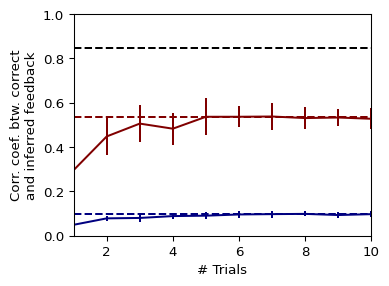

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Script that tests feedback learning with limited amount of trials.
Similar to Fig.4D
"""

import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn.linear_model as lm
import sklearn.metrics as m

#######################
# SET DIRECTORY
#######################
loaddir = 'data/fig4/'
savdir = 'figures/fig4/'
if not os.path.exists(savdir):
    os.mkdir(savdir)

#######################
# LOAD SIMULATION DATA
#######################
# load main data dictionaries
data = np.load(loaddir+'relearning_results.npy',allow_pickle=True).item()

activity = data['manifold']['original']['activity']
activity2 = activity.reshape(50,-1,800)
T = data['perturbations']['T']
T_within = data['perturbations']['T_within']
T_outside = data['perturbations']['T_outside']
fbw = np.linalg.pinv(T_within)
fbo = np.linalg.pinv(T_outside)

#######################
# ANALYSIS
#######################
reps = 20
corr = np.zeros((reps,50,2))
for i in range(50):
    for j in range(reps):
        pick_trials = np.random.choice(range(activity2.shape[0]),i+1,replace=False)
        until = (i+1)*180 # one trial = 180

        temp_act = activity2[pick_trials]
        temp_act = temp_act.reshape(-1,activity2.shape[-1])

        xw = temp_act @ T_within.T
        xo = temp_act @ T_outside.T
        y = temp_act

        regw = lm.LinearRegression()
        regw.fit(xw,y)
        rego = lm.LinearRegression()
        rego.fit(xo,y)

        corr[j,i,0] = np.corrcoef(fbw.ravel(),regw.coef_.ravel())[0,1]
        corr[j,i,1] = np.corrcoef(fbo.ravel(),rego.coef_.ravel())[0,1]

x = activity @ T.T
y = activity
reg = lm.LinearRegression()
reg.fit(x,y)
corr_initial = np.corrcoef(np.linalg.pinv(T).ravel(),reg.coef_.ravel())[0,1]

#%%
#######################
# PLOTS
#######################
col_w = '#800000'
col_o = '#000080'

plt.figure(figsize=(4,3),dpi=96)
plt.errorbar(np.linspace(1,50,50),np.mean(corr[:,:,0],axis=0),np.std(corr[:,:,0],axis=0),color=col_w)
plt.errorbar(np.linspace(1,50,50),np.mean(corr[:,:,1],axis=0),np.std(corr[:,:,1],axis=0),color=col_o)
plt.axhline(np.mean(corr[:,-1,0]),color=col_w,linestyle='--',label='WMP')
plt.axhline(np.mean(corr[:,-1,1]),color=col_o,linestyle='--',label='OMP')
plt.axhline(corr_initial,color='k',linestyle='--',label='Initial')
plt.ylabel('Corr. coef. btw. correct\nand inferred feedback')
plt.xlabel('# Trials')
plt.ylim(0,1)
plt.xlim(1,10)
plt.savefig(savdir+'fig4D.svg',bbox_inches='tight')

Loss in Trial 1 is 0.27946
Loss in Trial 2 is 0.41030
Loss in Trial 3 is 0.35385
Loss in Trial 4 is 0.49794
Loss in Trial 5 is 0.28733
Loss in Trial 6 is 0.17139
Loss in Trial 7 is 0.05654
Loss in Trial 8 is 0.17779
Loss in Trial 9 is 0.18429
Loss in Trial 10 is 0.18636
Loss in Trial 11 is 0.06259
Loss in Trial 12 is 0.03793
Loss in Trial 13 is 0.17822
Loss in Trial 14 is 0.15581
Loss in Trial 15 is 0.04635
Loss in Trial 16 is 0.08512
Loss in Trial 17 is 0.14569
Loss in Trial 18 is 0.66442
Loss in Trial 19 is 0.10020
Loss in Trial 20 is 0.36279
Loss in Trial 21 is 0.15580
Loss in Trial 22 is 0.08154
Loss in Trial 23 is 0.21556
Loss in Trial 24 is 0.20724
Loss in Trial 25 is 0.12186
Loss in Trial 26 is 0.07748
Loss in Trial 27 is 0.22244
Loss in Trial 28 is 0.07307
Loss in Trial 29 is 0.19566
Loss in Trial 30 is 0.05026
Loss in Trial 31 is 0.03981
Loss in Trial 32 is 0.10544
Loss in Trial 33 is 0.09847
Loss in Trial 34 is 0.24635
Loss in Trial 35 is 0.21646
Loss in Trial 36 is 0.10149
L

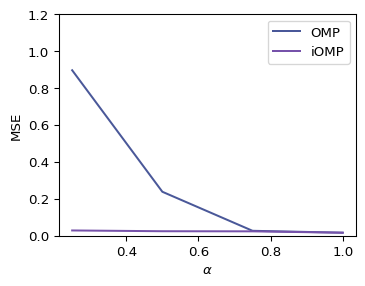

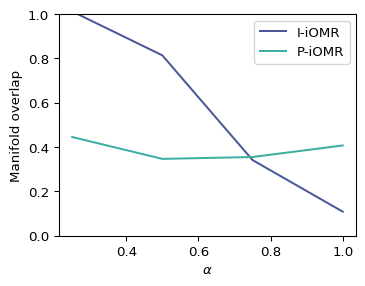

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation script for Figure 5 [Part 1].
 -> incremental outside learning
"""
# import packages
import numpy as np
import os
import sklearn.linear_model as lm

#######################
# SET DIRECTORY
#######################
# random seed for this simulation
seed_id = 0
# set directory where results should be saved
savdir = 'data/fig5/'
savdirfigs = 'figures/fig5/'
if not os.path.exists(savdir):
    os.mkdir(savdir)
if not os.path.exists(savdirfigs):
    os.mkdir(savdirfigs)
#######################
# PARAMETERS
#######################
np.random.seed(seed_id)
dt = 0.01
T = 2
time = np.arange(0,T,dt)
tsteps = len(time)
pulse_length = int(0.2/dt)
targets = 6
stimulus_type = 'constant' # constant, linear, normal
target_max = 0.2 # 0.2 or 0.01
# initial network learning
learning1_trials = 80
delta = 20.
# manifold calculation
manifold_trials = 50
reduced_dim = 10
# relearning
relearning_trials = 80
deltarec = 20.
alphas = np.array([0.25,0.5,0.75,1.])

# network parameters
N = 800
g = 1.5
p = 0.1
tau = 0.1

##################
# TOOLBOX
#################
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r

        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        tsteps = ext.shape[1]
        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        record_loss = np.zeros(trials)
        # start learning
        for t in range(trials):
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()
            # loop over time
            for i in range(1,tsteps):
                self.update_neurons(ext=ext[order[t],i])
                # learning part
                if i > ntstart and i%2==0:
                    c = decoder @ self.z
                    errc = c-target[order[t],i]
                    err1 = feedback @ errc
                    loss += np.mean(err1**2)
                    # ONLY RECURRENT WEIGHT UPDATE
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

####################
# HELPER FUNCTIONS #
####################
def create_stimulus(tsteps,pulse_steps,n_targets=6,amplitude=1.,twod=False):
    # create stimulus
    stimulus = np.zeros((n_targets,tsteps,n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_target(tsteps,pulse_steps,n_targets=6,stype='constant',target_max=0.2):
    # create target trajectories
    phis = np.linspace(0,2*np.pi,n_targets,endpoint=False)
    rs = np.zeros(tsteps)
    # TARGET DEFINITION
    if stype=='linear':
        # OPTION 1) linear for position
        rs[pulse_steps:] = np.linspace(0,target_max,tsteps-pulse_steps)
    elif stype=='normal':
        # OPTION 2) Gaussian speed profile
        xx = np.linspace(0,target_max,tsteps-pulse_steps)
        mu = target_max/2.
        sigma = target_max/8.
        rs[pulse_steps:] = target_max*np.exp(-(xx-mu)**2/(2*sigma**2))
    elif stype=='constant':
        # OPTION 3) constant speed
        rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):
        traj[j,:,0] = rs*np.cos(phis[j])
        traj[j,:,1] = rs*np.sin(phis[j])

    return traj

def decoder_training(inputP,target,order):
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], 2))
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
#    print('MSE = %.4f'%mse)
    return reg.coef_,mse

def feedback_model_training(X,Y):
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    return reg.coef_

def get_cost(result,target,order):
    cost = 0
    for j in range(result.shape[0]):
        error = result[j,:,:]-target[order[j],:,:]
        cost += np.mean(error**2)
    return cost

def select_random_perturbations(activity2,D,P):
    runs = 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

#%% INITIAL TRAINING

# create stimulus
stimulus = create_stimulus(tsteps, pulse_length, n_targets=targets, twod=False)

# create target
target = create_target(tsteps, pulse_length, n_targets=targets,
                                  stype=stimulus_type, target_max=target_max)

# create network
network = RNN(N=N,g=g,p=p,tau=tau,dt=dt,N_in=targets)
network.save(savdir+'network')
np.save(savdir+'W_initial',network.W)
w0 = network.W.copy()

#######################
# LEARNING 1
#######################
# create random decoder for initial learning
decoder = np.random.randn(2,network.N)
initial_decoder_fac = 0.04 * (target_max/0.2)
decoder *= (initial_decoder_fac / np.linalg.norm(decoder))
feedback = np.linalg.pinv(decoder)
stabilize_loss = network.relearn(learning1_trials, stimulus, pulse_length,
                      decoder, feedback, target, delta=delta)
np.save(savdir+'W_stabilized',network.W)
w1 = network.W.copy()

#######################
# MANIFOLD
#######################
activity,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                              ext=stimulus, ntstart=pulse_length)
# rearrange the activity a bit
activity2 = activity.reshape(manifold_trials,-1,network.N)
xi2 = xi.reshape(manifold_trials,-1,network.N)

#######################
# LEARNING 2
#######################
W_bci4,l4 = decoder_training(xi2[:,:,:reduced_dim],target[:,pulse_length:,:],order)

#######################
# SAVING
#######################
data = {'params':{'dt':dt,
                 'T':T,
                 'time':time,
                 'tsteps':tsteps,
                 'pulse_length':pulse_length,
                 'manifold_trials':manifold_trials,
                 'target_max':target_max,
                 'stimulus_type':stimulus_type,
                 'N':N,'tau':tau,'g':g,'p':p},
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{'learning_trials':learning1_trials,
                   'delta':delta,
                 'decoder':decoder,
                 'feedback':feedback,
                 'stabilize_loss':stabilize_loss},
    'decoding':{ 'reduced_dim':reduced_dim,
                 'weights':W_bci4,'loss':l4}}
np.save(savdir+'experiment_results',data)

manifold = {'original':{'activity':activity,
                'activity2':activity2,
                'xi':xi,
                'xi2':xi2,
                'cov':cov,'ev':ev,'evec':evec,'pr':pr,'order':order}}

#%% PERTURBATION

# original transformation
P = evec.real.T
D = np.zeros((2,network.N))
D[:,:reduced_dim] = W_bci4
T = D @ P
result_original = activity2 @ T.T
cost_original = get_cost(result_original,target[:,pulse_length:,:],order)

# select equal perturbation result shuffling seeds
idx_shuffling_seeds = select_random_perturbations(activity2,D,P) # within, outside
within_seed = idx_shuffling_seeds[0,0] # 79
outside_seed = idx_shuffling_seeds[0,1] # 189

#######################
# PERTURBATION
#######################
# within-manifold perturbation
np.random.seed(within_seed)
perm_matrix_within = np.eye(reduced_dim)
np.random.shuffle(perm_matrix_within)
D_permute = D.copy()
D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
T_within = D_permute @ P
result_within = activity2 @ T_within.T
cost_within = get_cost(result_within,target[:,pulse_length:,:],order)

# outside-manifold perturbation
np.random.seed(outside_seed)
perm_matrix_outside = np.eye(network.N)
np.random.shuffle(perm_matrix_outside)
P_permute = P @ perm_matrix_outside
T_outside = D @ P_permute
result_outside = activity2 @ T_outside.T
cost_outside = get_cost(result_outside,target[:,pulse_length:,:],order)

#%% relearning
###############################
# START INCREMENTAL LEARNING
###############################
w_outside = []
fb_outside_rec = []
cost_outside_retrained = []
cost_inc_retrained = []
fb_corr = []
exp_var = []
exp_var_new = []
for j in range(len(alphas)):
    print('Run %d'%(j+1))
    # set incremental BCI
    Tinc = (1-alphas[j])*T + (alphas[j])*T_outside
    Pinc = np.linalg.pinv(D) @ Tinc
    # RETRAIN
    network.W = np.copy(w1) # start from initial training setup
    fb_outside = np.linalg.pinv(Tinc) # take correct feedback for retraining
    # recurrent relearning
    loss_outside = network.relearn(relearning_trials, stimulus, pulse_length,
                      Tinc, fb_outside, target, delta=deltarec)
    w_outside.append(np.copy(network.W))

    # TESTING
    # simulate new activiy data
    activityt,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                                  ext=stimulus, ntstart=pulse_length)
    manifold.update({'outside'+str(j+1):{'activity':activityt,'order':order,
                           'cov':cov,'ev':ev,'evec':evec,'pr':pr}})
    # reshape
    activity2t = activityt.reshape(manifold_trials,-1,network.N)
    # calculate output
    result_outside = activity2t @ T_outside.T
    cost_outside_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))
    # calculate output
    result_outside = activity2t @ Tinc.T
    cost_inc_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))

    # calculate explained variance
    proj1 = manifold['original']['evec'].T @ cov @ manifold['original']['evec']
    proj2 = manifold['original']['evec'].T @ manifold['original']['cov'] @ manifold['original']['evec']
    proj3 = Pinc @ cov @ Pinc.T
    match1 = np.trace(proj1[:reduced_dim])/np.trace(cov)
    match2 = np.trace(proj2[:reduced_dim])/np.trace(manifold['original']['cov'])
    match3 = np.trace(proj3[:reduced_dim])/np.trace(cov)
    exp_var.append(match1/match2)
    exp_var_new.append(match3/match2)

    print('Goal: %.2f --- Outside: %.2f --- Incremental: %.2f'%(cost_original,
                    cost_outside_retrained[-1],cost_inc_retrained[-1]))
    print('Manifold match old: %.2f --- Manifold match new: %.2f'%(exp_var[-1],exp_var_new[-1]))

# save it
temp_data = {'alphas':alphas,'fb_corr':fb_corr,'exp_var':exp_var,
             'exp_var_new':exp_var_new,
             'cost_outside_retrained':cost_outside_retrained,
             'cost_inc_retrained':cost_inc_retrained,
             'T':T,'D':D,'P':P,'T_outside':T_outside}
np.save(savdir+'results',temp_data)
np.save(savdir+'manifold',manifold)
np.save(savdir+'wOM',w_outside)
np.save(savdir+'wfbOM',fb_outside)

#%%
# plot it
col_o = '#4a5899'
col_oi = '#7652aa'
col_oo = '#3CAEA3'

import matplotlib.pyplot as plt

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,cost_outside_retrained,col_o,label='OMP')
plt.plot(alphas,cost_inc_retrained,col_oi,label='iOMP')
plt.xlabel('$\\alpha$')
plt.ylabel('MSE')
plt.ylim(0,1.2)
plt.legend()
plt.savefig(savdirfigs+'Bperformance.svg',bbox_inches='tight')

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,exp_var,col_o,label='I-iOMR')
plt.plot(alphas,exp_var_new,col_oo,label='P-iOMR')
plt.legend()
plt.xlabel('$\\alpha$')
plt.ylabel('Manifold overlap')
plt.ylim(0,1)
plt.savefig(savdirfigs+'Cmanifoldoverlap.svg',bbox_inches='tight')

Run 1
Loss in Trial 1 is 0.76084
Loss in Trial 2 is 1.17764
Loss in Trial 3 is 0.40098
Loss in Trial 4 is 0.45292
Loss in Trial 5 is 1.08027
Loss in Trial 6 is 0.41573
Loss in Trial 7 is 1.07293
Loss in Trial 8 is 0.52279
Loss in Trial 9 is 0.42592
Loss in Trial 10 is 0.50986
Loss in Trial 11 is 0.10525
Loss in Trial 12 is 0.09893
Loss in Trial 13 is 0.45514
Loss in Trial 14 is 1.15265
Loss in Trial 15 is 0.14640
Loss in Trial 16 is 0.46629
Loss in Trial 17 is 0.18007
Loss in Trial 18 is 0.47564
Loss in Trial 19 is 0.18801
Loss in Trial 20 is 0.21467
Loss in Trial 21 is 0.19267
Loss in Trial 22 is 0.19121
Loss in Trial 23 is 0.12239
Loss in Trial 24 is 0.51868
Loss in Trial 25 is 0.05505
Loss in Trial 26 is 0.16429
Loss in Trial 27 is 0.11936
Loss in Trial 28 is 0.30569
Loss in Trial 29 is 0.29412
Loss in Trial 30 is 0.73680
Loss in Trial 31 is 1.09427
Loss in Trial 32 is 0.16410
Loss in Trial 33 is 0.27315
Loss in Trial 34 is 0.20852
Loss in Trial 35 is 0.17482
Loss in Trial 36 is 0.0

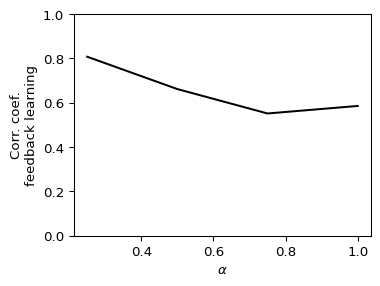

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation script for Figure 5 [Part 2].
 -> incremental outside learning
"""
# import packages
import numpy as np
import os
import sklearn.linear_model as lm

#######################
# SET DIRECTORY
#######################
# random seed for this simulation
seed_id = 0
# set directory where results should be saved
savdir = 'data/fig5/'
savdirfigs = 'figures/fig5/'
if not os.path.exists(savdir):
    os.mkdir(savdir)
if not os.path.exists(savdirfigs):
    os.mkdir(savdirfigs)

#######################
# PARAMETERS
#######################
np.random.seed(seed_id)
dt = 0.01
T = 2
time = np.arange(0,T,dt)
tsteps = len(time)
pulse_length = int(0.2/dt)
targets = 6
stimulus_type = 'constant' # constant, linear, normal
target_max = 0.2 # 0.2 or 0.01
# initial network learning
learning1_trials = 80
delta = 20.
# manifold calculation
manifold_trials = 50
reduced_dim = 10
# relearning
relearning_trials = 80
deltarec = 20.
alphas = np.array([0.25,0.5,0.75,1.])

##################
# TOOLBOX
#################
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r

        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        tsteps = ext.shape[1]
        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        record_loss = np.zeros(trials)
        # start learning
        for t in range(trials):
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()
            # loop over time
            for i in range(1,tsteps):
                self.update_neurons(ext=ext[order[t],i])
                # learning part
                if i > ntstart and i%2==0:
                    c = decoder @ self.z
                    errc = c-target[order[t],i]
                    err1 = feedback @ errc
                    loss += np.mean(err1**2)
                    # ONLY RECURRENT WEIGHT UPDATE
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

####################
# HELPER FUNCTIONS #
####################
def create_stimulus(tsteps,pulse_steps,n_targets=6,amplitude=1.,twod=False):
    # create stimulus
    stimulus = np.zeros((n_targets,tsteps,n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_target(tsteps,pulse_steps,n_targets=6,stype='constant',target_max=0.2):
    # create target trajectories
    phis = np.linspace(0,2*np.pi,n_targets,endpoint=False)
    rs = np.zeros(tsteps)
    # TARGET DEFINITION
    if stype=='linear':
        # OPTION 1) linear for position
        rs[pulse_steps:] = np.linspace(0,target_max,tsteps-pulse_steps)
    elif stype=='normal':
        # OPTION 2) Gaussian speed profile
        xx = np.linspace(0,target_max,tsteps-pulse_steps)
        mu = target_max/2.
        sigma = target_max/8.
        rs[pulse_steps:] = target_max*np.exp(-(xx-mu)**2/(2*sigma**2))
    elif stype=='constant':
        # OPTION 3) constant speed
        rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):
        traj[j,:,0] = rs*np.cos(phis[j])
        traj[j,:,1] = rs*np.sin(phis[j])

    return traj

def decoder_training(inputP,target,order):
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], 2))
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
#    print('MSE = %.4f'%mse)
    return reg.coef_,mse

def feedback_model_training(X,Y):
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    return reg.coef_

def get_cost(result,target,order):
    cost = 0
    for j in range(result.shape[0]):
        error = result[j,:,:]-target[order[j],:,:]
        cost += np.mean(error**2)
    return cost

def select_random_perturbations(activity2,D,P):
    runs = 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

#%% INITIAL TRAINING

# create stimulus
stimulus = create_stimulus(tsteps, pulse_length, n_targets=targets, twod=False)

# create target
target = create_target(tsteps, pulse_length, n_targets=targets,
                                  stype=stimulus_type, target_max=target_max)

########################
# LOAD from BC run
#######################
data = np.load(savdir+'results.npy',allow_pickle=True).item()
T_outside = data['T_outside']
alphas = data['alphas']
T = data['T']
D = data['D']
manifold0 = np.load(savdir+'manifold.npy',allow_pickle=True).item()

# create network
network = RNN()
network.load(savdir+'network')
w1 = np.load(savdir+'W_stabilized.npy')
network.W = w1.copy()


#%% relearning
###############################
# START INCREMENTAL LEARNING
###############################
w_outside = []
fb_outside_rec = []
cost_outside_retrained = []
cost_inc_retrained = []
fb_corr = []
exp_var = []
exp_var_new = []
manifold = {}
for j in range(len(alphas)):
    print('Run %d'%(j+1))
    # set incremental BCI
    Tinc = (1-alphas[j])*T + (alphas[j])*T_outside
    Pinc = np.linalg.pinv(D) @ Tinc
    # RETRAIN
    network.W = np.copy(w1) # start from initial training setup
    # load activity from perfect run and train feedback on this
    if j==0:
        act = manifold0['original']['activity']
    else:
        act = manifold0['outside'+str(j)]['activity']
    fb_outside = feedback_model_training(act @ Tinc.T ,act)

    # recurrent relearning
    loss_outside = network.relearn(relearning_trials, stimulus, pulse_length,
                      Tinc, fb_outside, target, delta=deltarec)
    w_outside.append(np.copy(network.W))

    # TESTING
    # simulate new activiy data
    activityt,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                                  ext=stimulus, ntstart=pulse_length)
    manifold.update({'outside'+str(j+1):{'activity':activityt,'order':order,
                           'cov':cov,'ev':ev,'evec':evec,'pr':pr}})
    # reshape
    activity2t = activityt.reshape(manifold_trials,-1,network.N)
    # calculate output
    result_outside = activity2t @ T_outside.T
    cost_outside_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))
    # calculate output
    result_outside = activity2t @ Tinc.T
    cost_inc_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))

    # calculate explained variance
    proj1 = manifold0['original']['evec'].T @ cov @ manifold0['original']['evec']
    proj2 = manifold0['original']['evec'].T @ manifold0['original']['cov'] @ \
                            manifold0['original']['evec']
    proj3 = Pinc @ cov @ Pinc.T
    match1 = np.trace(proj1[:reduced_dim])/np.trace(cov)
    match2 = np.trace(proj2[:reduced_dim])/np.trace(manifold0['original']['cov'])
    match3 = np.trace(proj3[:reduced_dim])/np.trace(cov)
    exp_var.append(match1/match2)
    exp_var_new.append(match3/match2)

    # only for fb learning
    c = np.corrcoef(np.linalg.pinv(Tinc).ravel(),fb_outside.ravel())
    fb_corr.append(c[0,1])
    print('FB corr=%.2f'%c[0,1])

    print('Goal: %.2f --- Outside: %.2f --- Incremental: %.2f'%(0.0,
                    cost_outside_retrained[-1],cost_inc_retrained[-1]))
    print('Manifold match old: %.2f --- Manifold match new: %.2f'%(exp_var[-1],exp_var_new[-1]))

# save it
temp_data = {'alphas':alphas,'fb_corr':fb_corr,'exp_var':exp_var,
             'exp_var_new':exp_var_new,
             'cost_outside_retrained':cost_outside_retrained,
             'cost_inc_retrained':cost_inc_retrained,
             'T':T,'D':D,'T_outside':T_outside}
np.save(savdir+'results_DEF',temp_data)
np.save(savdir+'manifold_DEF',manifold)
np.save(savdir+'wOM_DEF',w_outside)
np.save(savdir+'wfbOM_DEF',fb_outside)

#%% plot it
col_o = '#4a5899'
col_oi = '#7652aa'
col_oo = '#3CAEA3'

import matplotlib.pyplot as plt

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,fb_corr,'k')
plt.xlabel('$\\alpha$')
plt.ylabel('Corr. coef.\nfeedback learning')
plt.ylim(0,1)
plt.savefig(savdirfigs+'Dfeedbacklearning.svg',bbox_inches='tight')

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,cost_outside_retrained,col_o,label='OMP')
plt.plot(alphas,cost_inc_retrained,col_oi,label='iOMP')
plt.xlabel('$\\alpha$')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0,1.2)
plt.savefig(savdirfigs+'Eperformance.svg',bbox_inches='tight')

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,exp_var,col_o,label='I-iOMR')
plt.plot(alphas,exp_var_new,col_oo,label='P-iOMR')
plt.legend()
plt.xlabel('$\\alpha$')
plt.ylabel('Manifold overlap (%)')
plt.ylim(0,1)
plt.savefig(savdirfigs+'Fmanifoldoverlap.svg',bbox_inches='tight')

Run 1
Loss in Trial 1 is 0.76084
Loss in Trial 2 is 1.17764
Loss in Trial 3 is 0.40098
Loss in Trial 4 is 0.45292
Loss in Trial 5 is 1.08027
Loss in Trial 6 is 0.41573
Loss in Trial 7 is 1.07293
Loss in Trial 8 is 0.52279
Loss in Trial 9 is 0.42592
Loss in Trial 10 is 0.50986
Loss in Trial 11 is 0.10525
Loss in Trial 12 is 0.09893
Loss in Trial 13 is 0.45514
Loss in Trial 14 is 1.15265
Loss in Trial 15 is 0.14640
Loss in Trial 16 is 0.46629
Loss in Trial 17 is 0.18007
Loss in Trial 18 is 0.47564
Loss in Trial 19 is 0.18801
Loss in Trial 20 is 0.21467
Loss in Trial 21 is 0.19267
Loss in Trial 22 is 0.19121
Loss in Trial 23 is 0.12239
Loss in Trial 24 is 0.51868
Loss in Trial 25 is 0.05505
Loss in Trial 26 is 0.16429
Loss in Trial 27 is 0.11936
Loss in Trial 28 is 0.30569
Loss in Trial 29 is 0.29412
Loss in Trial 30 is 0.73680
Loss in Trial 31 is 1.09427
Loss in Trial 32 is 0.16410
Loss in Trial 33 is 0.27315
Loss in Trial 34 is 0.20852
Loss in Trial 35 is 0.17482
Loss in Trial 36 is 0.0

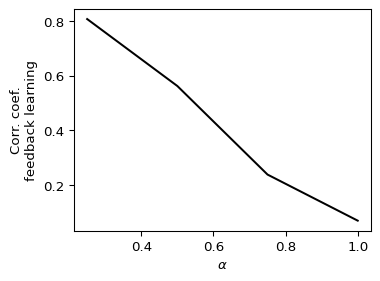

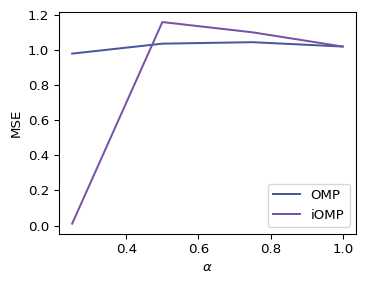

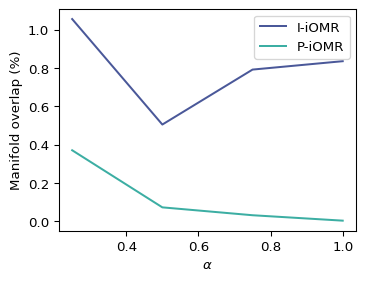

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulation script for Figure 5 [Part 3].
 -> incremental outside learning
"""
# import packages
import numpy as np
import os
import sklearn.linear_model as lm

#######################
# SET DIRECTORY
#######################
# random seed for this simulation
seed_id = 0
# set directory where results should be saved
savdir = 'data/fig5/'
savdirfigs = 'figures/fig5/'
if not os.path.exists(savdir):
    os.mkdir(savdir)
if not os.path.exists(savdirfigs):
    os.mkdir(savdirfigs)

#######################
# PARAMETERS
#######################
np.random.seed(seed_id)
dt = 0.01
T = 2
time = np.arange(0,T,dt)
tsteps = len(time)
pulse_length = int(0.2/dt)
targets = 6
stimulus_type = 'constant' # constant, linear, normal
target_max = 0.2 # 0.2 or 0.01
# initial network learning
learning1_trials = 80
delta = 20.
# manifold calculation
manifold_trials = 50
reduced_dim = 10
# relearning
relearning_trials = 80
deltarec = 20.
alphas = np.array([0.25,0.5,0.75,1.])

##################
# TOOLBOX
#################
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r

        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        tsteps = ext.shape[1]
        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        record_loss = np.zeros(trials)
        # start learning
        for t in range(trials):
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()
            # loop over time
            for i in range(1,tsteps):
                self.update_neurons(ext=ext[order[t],i])
                # learning part
                if i > ntstart and i%2==0:
                    c = decoder @ self.z
                    errc = c-target[order[t],i]
                    err1 = feedback @ errc
                    loss += np.mean(err1**2)
                    # ONLY RECURRENT WEIGHT UPDATE
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

####################
# HELPER FUNCTIONS #
####################
def create_stimulus(tsteps,pulse_steps,n_targets=6,amplitude=1.,twod=False):
    # create stimulus
    stimulus = np.zeros((n_targets,tsteps,n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_target(tsteps,pulse_steps,n_targets=6,stype='constant',target_max=0.2):
    # create target trajectories
    phis = np.linspace(0,2*np.pi,n_targets,endpoint=False)
    rs = np.zeros(tsteps)
    # TARGET DEFINITION
    if stype=='linear':
        # OPTION 1) linear for position
        rs[pulse_steps:] = np.linspace(0,target_max,tsteps-pulse_steps)
    elif stype=='normal':
        # OPTION 2) Gaussian speed profile
        xx = np.linspace(0,target_max,tsteps-pulse_steps)
        mu = target_max/2.
        sigma = target_max/8.
        rs[pulse_steps:] = target_max*np.exp(-(xx-mu)**2/(2*sigma**2))
    elif stype=='constant':
        # OPTION 3) constant speed
        rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):
        traj[j,:,0] = rs*np.cos(phis[j])
        traj[j,:,1] = rs*np.sin(phis[j])

    return traj

def decoder_training(inputP,target,order):
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], 2))
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
#    print('MSE = %.4f'%mse)
    return reg.coef_,mse

def feedback_model_training(X,Y):
    reg = lm.LinearRegression()
    reg.fit(X,Y)
    return reg.coef_

def get_cost(result,target,order):
    cost = 0
    for j in range(result.shape[0]):
        error = result[j,:,:]-target[order[j],:,:]
        cost += np.mean(error**2)
    return cost

def select_random_perturbations(activity2,D,P):
    runs = 200
    cost = np.zeros((runs,2))
    for j in range(runs):
        # set random seed for reproduction
        np.random.seed(j)
        # within-manifold perturbation
        perm_matrix_within = np.eye(reduced_dim)
        np.random.shuffle(perm_matrix_within)
        D_permute = D.copy()
        D_permute[:reduced_dim,:reduced_dim] = D[:reduced_dim,:reduced_dim] @ perm_matrix_within
        T_within = D_permute @ P
        result_within = activity2 @ T_within.T
        cost[j,0] = get_cost(result_within,target[:,pulse_length:,:],order)
        # set random seed for reproduction
        np.random.seed(j)
        # outside-manifold perturbation
        perm_matrix_outside = np.eye(network.N)
        np.random.shuffle(perm_matrix_outside)
        P_permute = P @ perm_matrix_outside
        T_outside = D @ P_permute
        result_outside = activity2 @ T_outside.T
        cost[j,1] = get_cost(result_outside,target[:,pulse_length:,:],order)
    # select closest to 1 perturbations
    dif = abs(cost-np.mean(cost))
    idx = np.argsort(dif,axis=0)
    return idx # first column seeds for within, second column seeds for outside

#%% INITIAL TRAINING

# create stimulus
stimulus = create_stimulus(tsteps, pulse_length, n_targets=targets, twod=False)

# create target
target = create_target(tsteps, pulse_length, n_targets=targets,
                                  stype=stimulus_type, target_max=target_max)

########################
# LOAD from BC run
#######################
data = np.load(savdir+'results.npy',allow_pickle=True).item()
T_outside = data['T_outside']
alphas = data['alphas']
T = data['T']
D = data['D']
manifold0 = np.load(savdir+'manifold.npy',allow_pickle=True).item()

# create network
network = RNN()
network.load(savdir+'network')
w1 = np.load(savdir+'W_stabilized.npy')
network.W = w1.copy()


#%% relearning
###############################
# START INCREMENTAL LEARNING
###############################
w_outside = []
fb_outside_rec = []
cost_outside_retrained = []
cost_inc_retrained = []
fb_corr = []
exp_var = []
exp_var_new = []
manifold = {}
for j in range(len(alphas)):
    print('Run %d'%(j+1))
    # set incremental BCI
    Tinc = (1-alphas[j])*T + (alphas[j])*T_outside
    Pinc = np.linalg.pinv(D) @ Tinc
    # RETRAIN
    network.W = np.copy(w1) # start from initial training setup
    # load activity from last run and train feedback on this
    if j==0:
        act = manifold0['original']['activity']
    else:
        act = manifold['outside'+str(j)]['activity']
    fb_outside = feedback_model_training(act @ Tinc.T ,act)

    # recurrent relearning
    loss_outside = network.relearn(relearning_trials, stimulus, pulse_length,
                      Tinc, fb_outside, target, delta=deltarec)
    w_outside.append(np.copy(network.W))

    # TESTING
    # simulate new activiy data
    activityt,cov,ev,evec,pr,xi,order = network.calculate_manifold(trials=manifold_trials,
                                                                  ext=stimulus, ntstart=pulse_length)
    manifold.update({'outside'+str(j+1):{'activity':activityt,'order':order,
                           'cov':cov,'ev':ev,'evec':evec,'pr':pr}})
    # reshape
    activity2t = activityt.reshape(manifold_trials,-1,network.N)
    # calculate output
    result_outside = activity2t @ T_outside.T
    cost_outside_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))
    # calculate output
    result_outside = activity2t @ Tinc.T
    cost_inc_retrained.append(get_cost(result_outside,target[:,pulse_length:,:],order))

    # calculate explained variance
    proj1 = manifold0['original']['evec'].T @ cov @ manifold0['original']['evec']
    proj2 = manifold0['original']['evec'].T @ manifold0['original']['cov'] @ manifold0['original']['evec']
    proj3 = Pinc @ cov @ Pinc.T
    match1 = np.trace(proj1[:reduced_dim])/np.trace(cov)
    match2 = np.trace(proj2[:reduced_dim])/np.trace(manifold0['original']['cov'])
    match3 = np.trace(proj3[:reduced_dim])/np.trace(cov)
    exp_var.append(match1/match2)
    exp_var_new.append(match3/match2)

    # only for fb learning
    c = np.corrcoef(np.linalg.pinv(Tinc).ravel(),fb_outside.ravel())
    fb_corr.append(c[0,1])
    print('FB corr=%.2f'%c[0,1])

    print('Goal: %.2f --- Outside: %.2f --- Incremental: %.2f'%(0.0,
                    cost_outside_retrained[-1],cost_inc_retrained[-1]))
    print('Manifold match old: %.2f --- Manifold match new: %.2f'%(exp_var[-1],exp_var_new[-1]))

# save it
temp_data = {'alphas':alphas,'fb_corr':fb_corr,'exp_var':exp_var,
             'exp_var_new':exp_var_new,
             'cost_outside_retrained':cost_outside_retrained,
             'cost_inc_retrained':cost_inc_retrained,
             'T':T,'D':D,'T_outside':T_outside}
np.save(savdir+'results_GHI',temp_data)
np.save(savdir+'manifold_GHI',manifold)
np.save(savdir+'wOM_GHI',w_outside)
np.save(savdir+'wfbOM_GHI',fb_outside)

#%% plot it
col_o = '#4a5899'
col_oi = '#7652aa'
col_oo = '#3CAEA3'

import matplotlib.pyplot as plt

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,fb_corr,'k')
plt.xlabel('$\\alpha$')
plt.ylabel('Corr. coef.\nfeedback learning')
plt.savefig(savdirfigs+'Gfeedbacklearning.svg',bbox_inches='tight')

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,cost_outside_retrained,col_o,label='OMP')
plt.plot(alphas,cost_inc_retrained,col_oi,label='iOMP')
plt.xlabel('$\\alpha$')
plt.ylabel('MSE')
plt.legend()
plt.savefig(savdirfigs+'Hperformance.svg',bbox_inches='tight')

plt.figure(figsize=(4,3),dpi=96)
plt.plot(alphas,exp_var,col_o,label='I-iOMR')
plt.plot(alphas,exp_var_new,col_oo,label='P-iOMR')
plt.legend()
plt.xlabel('$\\alpha$')
plt.ylabel('Manifold overlap (%)')
plt.savefig(savdirfigs+'Imanifoldoverlap.svg',bbox_inches='tight')